In [1]:
# RUN THIS CELL FOR FORMAT
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science 
**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader<br/>
<hr style="height:2pt">
# <img style="float: left; padding-right: 10px; width: 100px" src="assets/bot-banner-logo.png"> Final Project: Group 25 - Twitter Bot Detection 
**Project Team**: Yankai Su, Susheel Chandar Elango, Mohan Indugula<br/>
**Project Guide**: Brandon Lee<br/>

<hr style="height:2pt">

## Motivation

In today's world where there is thousands of tweets produced every second, the impact of tweets influencing about various widespread events ranging from day to day activities, stories, reviews or ratings on a product/company/individual, perceptions on a public body like a political party/movement, etc. is very high.<br>
<br>
The role and usage of automated accounts known as the social-media bots plays a widespread role in creating an influence or spreading a message/perception through content generated with no direct human involvement. Hence, the importance to identify such **social-media bots** and tweets generated by them is important to avoid being influenced by agendas or perceptions created by such automated accounts.<br>

## Problem Statement

This project aims at detecting the Twitter bots i.e. these automated twitter accounts by using the tweets data generated by these accounts. The project will use the live twitter data made available through the Twitter developer API to analyze tweeting patterns of an user and classify them as a human user or a Twitter bot. <br>
<br>
The project will take a **supervised approach** to perform classification by utilizing a set of pre-labelled data that already has identified users who are human users and Twitter bots. This pre-labelled data along with the features that is extracted from the raw tweets of these users will be used to train **classification models** to classify twitter bot users. The features extracted will also apply **Natural Language Processing** techniques to perform **sentiment analysis and Topic based Modeling** on the tweet data <br>

## Implementation Structure of the Notebook

The implementation in the notebook has been organized into different sections as per the Data Science lifecycle process that was followed during the execution of this project    
1) Interfacing with Twitter Developer API     
2) Data Preparation - Includes Raw Data Collection, Data Preprocessing, Data Cleansing and Standardization, Feature Extraction    
3) Exploratory Data Analysis         
4) Model Training and Validation - Includes training and validation of all the classification models, stacking metalearner and the Topic based classification model training      
5) Train and Validation Results and Statistics     
6) Test Data Preparation and Models Validation using test data set        

In [154]:
%matplotlib inline
from IPython.display import Markdown, display

import sys
import math
import os
import random
random.seed(112358)
import base64
import string
import re
from collections import Counter

import csv
import jsonpickle
import json

from time import sleep
from datetime import datetime

import pandas as pd
import numpy as np
import numpy.random as nd
from scipy.stats import expon

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

import keras 
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.constraints import MaxNorm
from keras import regularizers

import tweepy # Library to access Twitter Developer API

# Natural Language Processing related Libraries used for Sentiment Analysis and Topic Modeling
from textblob import TextBlob #For Sentiment Analysis

import nltk # Natural Language Toolkit for Topic Modeling
nltk.download('stopwords')

import spacy # NLP Library
nlp = spacy.load('en_core_web_sm')

from nltk.corpus import stopwords

from spacy.lang.en import English
parser = English()

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tv775c\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [79]:
def printmd(string):
    display(Markdown(string))
    
#Seaborn settings
sns.set(style="darkgrid")
flatui = ["#34495e", "#1abc9c", "#e74c3c", "#2ecc71", "#9b59b6", "#3498db", "#95a5a6"]
sns.set_palette(flatui)

#Pandas Settings
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

# Global Constants
TWEET_EXTRACT_LOCATION_TRAIN = 'tweet_extract_data/' # Location of extracted Tweet files for Train and Validation
TWEET_EXTRACT_LOCATION_TEST = 'tweet_test_extract_data/' # Location of extracted Tweet files for Test Data set
DATA_FILE_SUFFIX = '.dat' # Extension used for the JSON data files
SUCCESS_USER_STATS = 'success_user_stats.csv' # Data file containing list of users for whom valid data was collected
RESTRICTED_USER_STATS = 'restricted_user_stats.csv' # Data file containing list of restricted users
CONSOLIDATED_FEATURES = 'consolidated_features.csv' # Data file containing list of consolidated features for all users

In [80]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

# <img style="float: left; padding-right: 10px; width: 50px" src="assets/twitter.png"> Instantiate Connection with Twitter Developer API
**Use the API Key and Secret code provided by twitter for the app subscription and initiate a connection using tweepy**

In [81]:
# Replace the API_KEY and API_SECRET with your application's key and secret.
API_KEY = "<USE_SUBSCRIPTION_APP_API_KEY>"
API_SECRET = "<USE_SUBSCRIPTION_APP_API_SECRET>"

# Authenticate user API Key and Secret code
auth = tweepy.AppAuthHandler(API_KEY, API_SECRET)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
 
if (not api):
    print ("Can't Authenticate")
    sys.exit(-1)

In [82]:
# Method Implementation to Fetch tweets posted by a specified user
# NOTE: Twitter only allows access to a users most recent 3200 tweets with this method
def get_all_tweets_json(user_id, no_of_tweets=200, tweet_max_id = None):
    '''Fetch the most recent tweets as per no_of_tweets mentioned for the given user_Id from twitter.
        
       Args:
           user_id: Twitter User ID of an user as recognized by Twitter developer API.
           no_of_tweets: No of recent tweets to fetch for the user. Default set to 200
           tweet_max_id: The Max ID of the twitter status that should be fetched
                  
       Returns:
           new_tweets: Array of tweets containing individual tweets in JSON format
    '''    
    
    # Array initiated to hold the JSON formatted tweets extracted for the user
    new_tweets = []
    try:
        # Make initial request for most recent tweets (200 is the maximum allowed count) raised by user
        if tweet_max_id == None:
            new_tweets = api.user_timeline(user_id = user_id ,count = no_of_tweets)
        else:
            new_tweets = api.user_timeline(user_id = user_id ,count = no_of_tweets, max_id=tweet_max_id)
    except tweepy.TweepError as e:
        raise
    except tweepy.RateLimitError as rate_err:
        raise
        
    return new_tweets

# <img style="float: left; padding-right: 10px; width: 50px" src="assets/data.png"> Data Preparation

<h2>Raw Data Collection</h2>

**Read Pre-labelled twitter user set obtained from botometer (varo-2017)**

In [83]:
# Read the Pre-classified data set containing twitter user labeled as either Bots (1) or Human Users (0)
labelled_df=pd.read_csv('varol-2017.dat', delimiter='\t' ,header=None)

# Filter the Data frame and limit to the User ID and Bot Flag columns
labelled_df.columns = ['user_id', 'bot_flg']

# Determine no of users in the labelled data classified as Bots(1) and who are determined as Human Users (0)
labelled_df.groupby(['bot_flg']).count()

user_id
bot_flg         
0           1747
1            826

**Extract Tweet data from Twitter developer API for twitter users in the pre-labelled data set**

In [84]:
# Method Implementation to extract tweets for a set of users
def extract_tweets_for_users(labelled_users, target_location):
    '''Extract upto 3200 tweets for the given set of labelled users
        and store the tweets for each individual user in <user_id>.data file in the target_location
        stats of success_users for whom data was retreived successfully and restricted_users for 
        whom data retreival was not successful are also written out to the target location
        
       Args:
           labelled_users: Datframe containing set of labelled users with twitter_user_id
           target_location: Location where the data files with extracted tweets should be written
                  
       Returns:
           success_users: Dataframe containining list of successful users for whom data was extracted
           restricted_users: Dataframe containining list of restricted users
    '''  

    # Instantiate a Dataframe to store the restricted users whose information cannot be accessed
    restricted_users = pd.DataFrame(columns=['user_id', 'bot_flg', 'reason'])
    success_users = pd.DataFrame(columns=['user_id', 'bot_flg'])

    # Loop through each user in labelled_users and write the json extracts into '<user_id>.dat' file
    max_tweet_cnt = 3000
    stop_process = False
    for index, row in labelled_users.iterrows():
        user_id = row['user_id']
        curr_id = None # Latest tweet ID retreived for the current user

        # Check if rate limit has reached by checking stop_process flag before proceeding
        if stop_process == True:
            break

        # Open Write handle for '<user_id>.dat' file to write the extracted json feeds
        with open(target_location + str(user_id) + DATA_FILE_SUFFIX, 'w') as f:

            try:
                # Initiate remaining count to max count
                remaining_cnt = max_tweet_cnt

                # Check if still max count has not reached by checking remaining count
                while remaining_cnt > 0:

                    tweet_cnt = 0
                    tweet_extracts = None
                    # Check if tweets have been retreived for user in this session
                    # by checking the id of the last tweet retreived
                    if curr_id == None:
                        tweet_extracts = get_all_tweets_json(user_id, 200)
                    else:
                        tweet_extracts = get_all_tweets_json(user_id, 200, curr_id)

                    # Encode each json tweet retreived and write to the user dat file
                    for tweet in tweet_extracts:
                        curr_id = tweet._json.get('id') - 1
                        f.write(jsonpickle.encode(tweet._json, unpicklable=False) +'\n')
                        tweet_cnt = tweet_cnt + 1

                    # Update remaining count to reach max limit
                    remaining_cnt = max_tweet_cnt - tweet_cnt

                    # If no tweets was available to retreive then move to next user
                    if tweet_cnt == 0:
                        break;

                # Append stats of current users to success users dataframe
                success_users = success_users.append({'user_id': user_id, 'bot_flg': row['bot_flg']}
                                                     , ignore_index=True)
            except tweepy.TweepError as e:
                # Handle TweepError encountered during extraction and update restricted_users dataframe
                restricted_users = restricted_users.append({'user_id': user_id, 'bot_flg': row['bot_flg']
                                                            , 'reason': e.reason}, ignore_index=True)
            except tweepy.RateLimitError as rate_err:
                # Handle limit reached error and mark to stop retreival process
                print('Tweet Data Extraction terminated due to RATE LIMIT ERROR')
                print('Current User ID - ' + user_id)
                stop_process = True

        # Close user data file handle
        f.close()

    # Write Success User and Restricted user stats to CSV file
    success_users.to_csv(target_location + SUCCESS_USER_STATS, index=False)
    restricted_users.to_csv(target_location + RESTRICTED_USER_STATS, index=False)
    
    return success_users, restricted_users


In [85]:
# MARKED FOR EXECUTION AS NEEDED - NOTE - EXTRACTION TAKES A LONG TIME
# Download the latest 3000 tweets as json for each user in varol-2017.dat (labelled_df)

# success_users, restricted_users = extract_tweets_for_users(labelled_df, TWEET_EXTRACT_LOCATION_TRAIN)

<h2>Data Preprocessing</h2>

**Utility methods to help in Data Processing**

In [127]:
# Lambda function to check if an Object is NULL and return 0 if yes and 1 if not null
check_if_null = lambda obj: 0 if obj == None else 1

# Lambda function to Binary code a boolean value - True to 1 and False to 0
binary_code_boolean = lambda boolean: 1 if boolean == True else 0

# Lambda function to get count of a list
get_count = lambda array: 0 if (array == None or (type(array) is not list)) else len(array)

# Utility function to separate hashtag topics from the given string phrase
def extract_hash_tags(s):
    return set(part[1:] for part in s.split() if part.startswith('#'))

# Utility method to Clean the provided text content
def cleanTagText(text):
    text = str(text.encode(encoding='ascii',errors='replace'))
    text = text.strip().replace("\n", " ").replace("\r", " ").replace("\\n", " ").replace("\\r", " ")
    text = text.replace("?", "").replace("\'","").replace("_","").replace("~","").replace("\"","")
    text = text.lower()
    return text

**Parse the JSON feeds of the tweets received and create a flattened data frame with extracted and preprocessed attributes**   

**Cleanse, modify and update attributes extracted from the tweet feeds**

<h2>Data Cleansing and Standardisation</h2>

**Parse the JSON feeds of the tweets received and create a flattened data frame with extracted and preprocessed attributes**   
**Cleanse, modify and update attributes extracted from the tweet feeds**

In [128]:
# Method Implementation to parse and extract features from tweets posted by a specified user
# Approx 14 User level features and 17 Tweet level features are extracted from the Tweet objects

def parse_and_extract_tweets_for_user(user_id, source_location):
    '''Parse the JSON tweets for the given user id and extract the features.
        Features extracted will be user level features and tweet level features
        
       Args:
           user_id: Twitter User ID of an user as recognized by Twitter developer API.
           source_location: Location of the dat files from which tweets are to be extracted
       Returns:
           user_features_df: Dataframe containining user level features for the given user
           tweet_features_df: Dataframe of tweets containing features extracted from individual tweets for user
           
    '''  
    user_features_df = None
    tweets_list = []
    has_user_data = False
    
    # Parse the JSON Feed file with tweets obtained from Twitter for the given User ID
    with open(source_location + str(user_id) + DATA_FILE_SUFFIX) as fjson:
        tweet_jsons = fjson.readlines()
    fjson.close()
    
    # Loop through all tweets and extract tweet level features for each tweet
    # Extract User level features from the tweet object just for the first tweet
    for current_tweet in tweet_jsons:

        # Load the tweet object into a dictionary by decoding the JSON string
        tweet_dict = json.loads(current_tweet)
        
        # Extract User level features just from the first tweet
        # All Boolean attributes are binary encoded to 1 (True) or 0 (False)
        if has_user_data == False:
            usr_features = {}
            
            # Get the user object as dictionary from the tweet
            user_dict = tweet_dict.get('user', {})
            
            # Get ID of the user (Number)
            usr_features['user_id'] = user_dict.get('id')
            
            # Boolean attribute - True indicates user has not altered default profile
            usr_features['default_profile'] = binary_code_boolean(user_dict.get('default_profile'))
            # Boolean attribute - True indicates user has not altered default profile Image
            usr_features['default_profile_image'] = binary_code_boolean(user_dict.get('default_profile_image'))

            # Int attribute - Number of tweets user has liked in lifetime of account
            usr_features['favourites_count'] = user_dict.get('favourites_count')
            # Int attribute - Number of current followers for this account
            usr_features['followers_count'] = user_dict.get('followers_count')
            # Int attribute - Number of users being followed by this account
            usr_features['friends_count'] = user_dict.get('friends_count')
            # Int attribute - Number of public lists that this user is a member of
            usr_features['listed_count'] = user_dict.get('listed_count')
            # Int attribute - Number of tweets (including retweets) issued by this user
            usr_features['statuses_count'] = user_dict.get('statuses_count')

            # Boolean attribute - True - Indicates user has enabled geo tagging of their tweets
            usr_features['geo_enabled'] = binary_code_boolean(user_dict.get('geo_enabled'))
            # Boolean attribute - True - Indicates user has chosen to protect their tweets
            usr_features['protected'] = binary_code_boolean(user_dict.get('protected'))
            # Boolean attribute - True - Indicates user has a verified account
            usr_features['verified'] = binary_code_boolean(user_dict.get('verified'))
                        
            # Twitter Internal attributes
            # Boolean attribute - True - Indicates user has an extended profile
            usr_features['has_extended_profile'] = binary_code_boolean(user_dict.get('has_extended_profile'))
            # Boolean attribute - True - Indicates if the user is a participant of Translator community 
            usr_features['is_translator'] = binary_code_boolean(user_dict.get('is_translator'))
            
            # String attribute - Denotes the code of the language set for the user account
            usr_features['user_lang'] = user_dict.get('lang')
            
            # Create a dataframe for the user features
            user_features_df = pd.DataFrame(data=usr_features, index=[0])
            has_user_data = True
    
        # Extract Tweet Level Features to be consolidated and grouped to user level during data preparation
        tweet_features ={}
        tweet_features['user_id'] = user_id
        
        # Get ID of the Tweet (Number)
        tweet_features['tweet_id'] = tweet_dict.get('id')
    
        # Perform SENTIMENT ANALYSIS on the text content of the tweet
        sentiment_score = TextBlob(tweet_dict.get('text')).sentiment
        # Calculate Polarity (Level of emotion) score (Range 0-1) from sentiment analysis 
        tweet_features['senti_polarity'] = sentiment_score.polarity
        # Calculate Subjectivity score (Range 0-1) from sentiment analysis
        # 0 is very Objective and 1 is very subjective
        tweet_features['senti_subjectivity'] = sentiment_score.subjectivity
    
        # String attribute - Indicates date and timestamp when the tweet was created
        # Convert to Date/Time object
        tweet_features['created_at'] = pd.to_datetime(tweet_dict.get('created_at'))
   
        # Int attribute - Indicates number of times this tweet has been liked by users
        tweet_features['favorite_count'] = tweet_dict.get('favorite_count')
        # Int attribute - Indicates number of times this tweet has been retweeted by users
        tweet_features['retweet_count'] = tweet_dict.get('retweet_count')
    
        # Boolean attribute - True Indicates that tweet is associated with a place
        tweet_features['place_reference'] = check_if_null(tweet_dict.get('place')) #**
        # Boolean attribute - True Indicates that tweet contains possibly sensitive content
        tweet_features['possibly_sensitive'] = binary_code_boolean(tweet_dict.get('possibly_sensitive')) #**
        # Boolean attribute - True Indicates that tweet is a reply to an existing tweet
        tweet_features['is_a_reply'] = check_if_null(tweet_dict.get('in_reply_to_status_id')) #**
        # Boolean attribute - True Indicates that this tweet is a Quoted tweet
        tweet_features['is_quote_status'] = binary_code_boolean(tweet_dict.get('is_quote_status')) #**
        # Boolean attribute - True Indicates that this tweet is a retweet of an existing tweet
        tweet_features['is_a_retweet'] = check_if_null(tweet_dict.get('retweeted_status')) #**
    
        # Extract Info on Media and external entitities associated with the tweet
        entities_dict = tweet_dict.get('entities', {}) #**
        # Int attribute - Indicates number of Hash tags referred to in the tweet
        tweet_features['hash_tags_cnt'] = get_count(entities_dict.get('hashtags'))
        # Int attribute - Indicates number of media content attached with the tweet
        tweet_features['media_cnt'] = get_count(entities_dict.get('media'))
        # Int attribute - Indicates number of URLs and links embedded in the tweet
        tweet_features['url_ref_cnt'] = get_count(entities_dict.get('urls'))
        # Int attribute - Indicates number of symbols embedded in the tweet
        tweet_features['symbols_cnt'] = get_count(entities_dict.get('symbols'))
        # Int attribute - Indicates number of User references in the tweet
        tweet_features['user_ref_cnt'] = get_count(entities_dict.get('user_mentions'))
        
        # Extract Hash tags from the tweet text to perform topic modeling
        hash_tags = ''
        if get_count(entities_dict.get('hashtags')) > 0:
            hash_tags = ' '.join(list(filter(None,extract_hash_tags(cleanTagText(tweet_dict.get('text'))))))
        tweet_features['hash_tags'] = hash_tags
        
        # Add the tweet to the list of user tweets parsed
        tweets_list.append(tweet_features)
        
    # Create a dataframe for the tweet features
    tweet_features_df = pd.DataFrame(data=tweets_list) 
        
    return user_features_df, tweet_features_df

<h2>Feature Extraction</h2>

**Extract, Derive and Create new features from the attributes extracted from the tweet feeds**

In [88]:
# Method implementation to consolidate, merge tweet level stats gathered to user level
# Stats are merged based on the number of tweets collected for the user. Usually ~3000-3200

def Merge_tweet_stats_to_user_level(user_id, tweet_cnt, tweet_features_df):
    '''Parse the JSON tweets for the given user id and extract the features.
        Features extracted will be user level features and tweet level features
        
       Args:
           user_id: Twitter User ID of an user as recognized by Twitter developer API.
           tweet_cnt: Count of tweets extracted for the user
           tweet_features_df: Dataframe of tweets containing features extracted from individual tweets for user
       Returns:
           tweet_merged_df: Dataframe for tweet level features consolidated to user level
    ''' 
    merged_stats = {}
    
    # Calculate Mean of Sentiment analysis scores across all messages created by user
    # Value range is between 0 and 1
    merged_stats['senti_polarity'] = round(tweet_features_df['senti_polarity'].mean(),3)
    merged_stats['senti_subjectivity'] = round(tweet_features_df['senti_subjectivity'].mean(),3)
    
    # Calculate Mean stats of all binary value (0 or 1) features
    merged_stats['place_reference'] = round(tweet_features_df['place_reference'].mean(),3)
    merged_stats['possibly_sensitive'] = round(tweet_features_df['possibly_sensitive'].mean(),3)
    merged_stats['is_a_reply'] = round(tweet_features_df['is_a_reply'].mean(),3)
    merged_stats['is_quote_status'] = round(tweet_features_df['is_quote_status'].mean(),3)
    merged_stats['is_a_retweet'] = round(tweet_features_df['is_a_retweet'].mean(),3)
    
    # Calculate Mean stats of all integer value features
    merged_stats['favorite_count'] = round(tweet_features_df['favorite_count'].mean(),3)
    merged_stats['retweet_count'] = round(tweet_features_df['retweet_count'].mean(),3)
    merged_stats['hash_tags_cnt'] = round(tweet_features_df['hash_tags_cnt'].mean(),3)
    merged_stats['media_cnt'] = round(tweet_features_df['media_cnt'].mean(),3)
    merged_stats['url_ref_cnt'] = round(tweet_features_df['url_ref_cnt'].mean(),3)
    merged_stats['symbols_cnt'] = round(tweet_features_df['symbols_cnt'].mean(),3)
    merged_stats['user_ref_cnt'] = round(tweet_features_df['user_ref_cnt'].mean(),3)
  
    # Calculate the Tweeting frequency in Hours based on Creation Time Interval and total count of tweets by user
    creation_intrval = tweet_features_df['created_at'].max() - tweet_features_df['created_at'].min()
    merged_stats['tweet_freq_hrs'] = round((creation_intrval.days*24 + 
                                            creation_intrval.seconds//3600) / int(tweet_cnt),3)
    
    # Consolidate all hash tags from all user messages into 1 string
    hash_tags = tweet_features_df['hash_tags'].str.cat(sep=' ').strip()
    #str(tweet_features_df['hash_tags'].apply(' '.join)).strip()
    if hash_tags == '':
        hash_tags = 'none'
    merged_stats['hash_tags'] = ' '.join(set(hash_tags.split()))
    
    # Create a Dataframe with the Merged stats
    tweet_merged_df = pd.DataFrame(data=merged_stats, index=[0])
    
    return tweet_merged_df

In [89]:
def consolidate_features_at_user_level(source_location):
    '''Extract, parse and Consolidate all Features for each user in the extracted data set
       
       Args:
           source_location: Location of the dat files from which tweets are to be extracted
       Returns:
           consolidated_ftrs_df: Dataframe with consolidated features for all users
    ''' 
    # Create a Dataframe with users for whom data was extracted successfully
    success_users_df = pd.read_csv(source_location + SUCCESS_USER_STATS)

    # For each user.. Parse, extract features on user and tweet level.. then merge tweet level features to user level
    consolidated_ftrs_df = pd.DataFrame()
    for index, row in success_users_df.iterrows():
        # Parse, extract features on user and tweet level
        user_features_df, tweet_features_df = parse_and_extract_tweets_for_user(row['user_id'], source_location)   
        tweet_count = len(tweet_features_df.index)

        if tweet_count > 0:
            # Merge tweet level features to user level based on aggregation
            tweet_merged_df = Merge_tweet_stats_to_user_level(row['user_id'], tweet_count, tweet_features_df)

            # Merge the user and aggregated tweet features and Concat to a consolidated Dataframe
            consolidated_ftrs_df = consolidated_ftrs_df.append(pd.concat([user_features_df, tweet_merged_df]
                                                                         , axis=1), ignore_index=True);

    # Merge the consolidated features with the pre classification labels
    consolidated_ftrs_df = consolidated_ftrs_df.join(success_users_df.set_index('user_id'), on='user_id')

    # Just In Case - Drop NaN and Null rows
    consolidated_ftrs_df = consolidated_ftrs_df.dropna()    

    # Write the Consolidated features to the source location for later retreival
    consolidated_ftrs_df.to_csv(source_location + CONSOLIDATED_FEATURES, index=False)
    
    return consolidated_ftrs_df

In [90]:
consolidated_ftrs_df = pd.read_csv(TWEET_EXTRACT_LOCATION_TRAIN + CONSOLIDATED_FEATURES)

# MARKED FOR EXECUTION AS NEEDED - NOTE - PARSING and CONSOLIDATES TAKES A LONG TIME
# Extract and consolidate all features for every user
# consolidated_ftrs_df = consolidate_features_at_user_level(TWEET_EXTRACT_LOCATION_TRAIN)

consolidated_ftrs_df.describe()

user_id  default_profile  default_profile_image  favourites_count  followers_count  friends_count  listed_count  statuses_count  geo_enabled  protected     verified  has_extended_profile  is_translator  senti_polarity  senti_subjectivity  place_reference  possibly_sensitive   is_a_reply  is_quote_status  is_a_retweet  favorite_count  retweet_count  hash_tags_cnt    media_cnt  url_ref_cnt  symbols_cnt  user_ref_cnt  tweet_freq_hrs      bot_flg
count  2.139000e+03      2139.000000            2139.000000       2139.000000      2139.000000    2139.000000   2139.000000     2139.000000  2139.000000     2139.0  2139.000000           2139.000000         2139.0     2139.000000         2139.000000      2139.000000         2139.000000  2139.000000      2139.000000   2139.000000     2139.000000    2139.000000    2139.000000  2139.000000  2139.000000  2139.000000   2139.000000     2139.000000  2139.000000
mean   1.364801e+09         0.421225               0.039271       6027.263675      1679.877513     795.085554     31.751286    13783.351566     0.495091        0.0     0.011688              0.407200            0.0        0.099820            0.275848         0.031882            0.006391     0.126498         0.056089      0.341183        0.883115    2914.856304       0.415956     0.176507     0.409275     0.000877      0.676613       20.980187     0.328191
std    1.303371e+09         0.493871               0.194284      14488.054908      8198.758782    1960.674949    150.966719    25192.829540     0.500093        0.0     0.107501              0.491428            0.0        0.083318            0.114966         0.095798            0.063096     0.164704         0.081115      0.325837        3.621058    7006.615150       0.616179     0.193152     0.356946     0.010571      0.484800      100.018217     0.469664
min    1.325300e+04         0.000000               0.000000          0.000000         0.000000       0.000000      0.000000        1.000000     0.000000        0.0     0.000000              0.000000            0.0       -0.743000            0.000000         0.000000            0.000000     0.000000         0.000000      0.000000        0.000000       0.000000       0.000000     0.000000     0.000000     0.000000      0.000000        0.000000     0.000000
25%    2.365333e+08         0.000000               0.000000         94.000000       125.500000     133.000000      1.000000     2242.000000     0.000000        0.0     0.000000              0.000000            0.0        0.049000            0.226500         0.000000            0.000000     0.003000         0.002000      0.050000        0.034500       8.499000       0.048000     0.050000     0.122000     0.000000      0.315500        4.902000     0.000000
50%    7.511447e+08         0.000000               0.000000       1325.000000       347.000000     343.000000      4.000000     5561.000000     0.000000        0.0     0.000000              0.000000            0.0        0.086000            0.300000         0.000000            0.000000     0.058000         0.022000      0.242000        0.181000     441.084000       0.159000     0.122000     0.258000     0.000000      0.663000       10.175000     0.000000
75%    2.582829e+09         1.000000               0.000000       5977.500000       847.000000     785.000000     16.000000    14295.500000     1.000000        0.0     0.000000              1.000000            0.0        0.137000            0.344000         0.005000            0.000000     0.192000         0.076500      0.577500        0.636500    2477.525000       0.566000     0.233000     0.723500     0.000000      0.987500       17.408500     1.000000
max    4.627817e+09         1.000000               1.000000     289192.000000    247923.000000   35509.000000   4569.000000   338380.000000     1.000000        0.0     1.000000              1.000000            0.0        0.781000            0.993000         1.000000            1.000000     1.000000         0.645000      1.000000       80.

In [91]:
# Preview the consolidated features
consolidated_ftrs_df.head()

user_id  default_profile  default_profile_image  favourites_count  followers_count  friends_count  listed_count  statuses_count  geo_enabled  protected  verified  has_extended_profile  is_translator user_lang  senti_polarity  senti_subjectivity  place_reference  possibly_sensitive  is_a_reply  is_quote_status  is_a_retweet  favorite_count  retweet_count  hash_tags_cnt  media_cnt  url_ref_cnt  symbols_cnt  user_ref_cnt  tweet_freq_hrs                                          hash_tags  bot_flg
0    44324787                1                      0             15011               11            141             1           14809            0          0         0                     0              0        ko           0.011               0.043              0.0                 0.0       0.002            0.001         0.998           0.000       1281.749          3.389      0.892        0.229          0.0         1.024           1.897  twice1starenatour sonchaeyoung fes2018 twice n...        0
1  3098421349                1                      0                88              273            912             5            2263            0          0         0                     0              0        en           0.196               0.347              0.0                 0.0       0.000            0.003         0.023           0.270          0.269          0.601      0.444        0.619          0.0         0.028          14.288  hilarious petodor lenses bedrooms arearugs tip...        1
2   554067867                1                      0              2707               28           1586            18            5357            0          0         0                     0              0        en           0.134               0.304              0.0                 0.0       0.000            0.038         1.000           0.000        372.719          1.159      0.146        0.440          0.0         1.138           6.695  momentofclarity makeyourownlane cw3 prettyeyes...        1
3   256597786                1                      0                10              162            482             3            1206            0          0         0                     0              0        en           0.283               0.335              0.0                 0.0       0.011            0.040         0.594           0.037       1757.059          1.048      0.056        0.412          0.0         1.279          57.982  thefifthwatches lilyjames! vudu esuranceswe pr...        1
4   103351486                0                      0                55              182            145             4            6595            0          0         0                     0              0        en           0.015               0.130              0.0                 0.0       0.006            0.000         0.008           0.017        112.968          0.007      0.002        0.948          0.0         0.019           8.089  trump2016 throwbackthursday deplorable america...        1

In [92]:
# Drop user_id from the dataframe as that is not needed for classification
consolidated_ftrs_df = consolidated_ftrs_df.drop(["user_id"], axis=1)

# <img style="float: left; padding-right: 10px; width: 50px" src="assets/EDA.png">Exploratory Data Analysis on the extracted features and attributes

<div class="gc"> <b>Matrix plot of User Level count features across Bot and Human classes</b> </div>

In [93]:
# Separate Bot and Human data into separate frames for analysis
df_bot = consolidated_ftrs_df[consolidated_ftrs_df.bot_flg==1]
df_human = consolidated_ftrs_df[consolidated_ftrs_df.bot_flg==0]

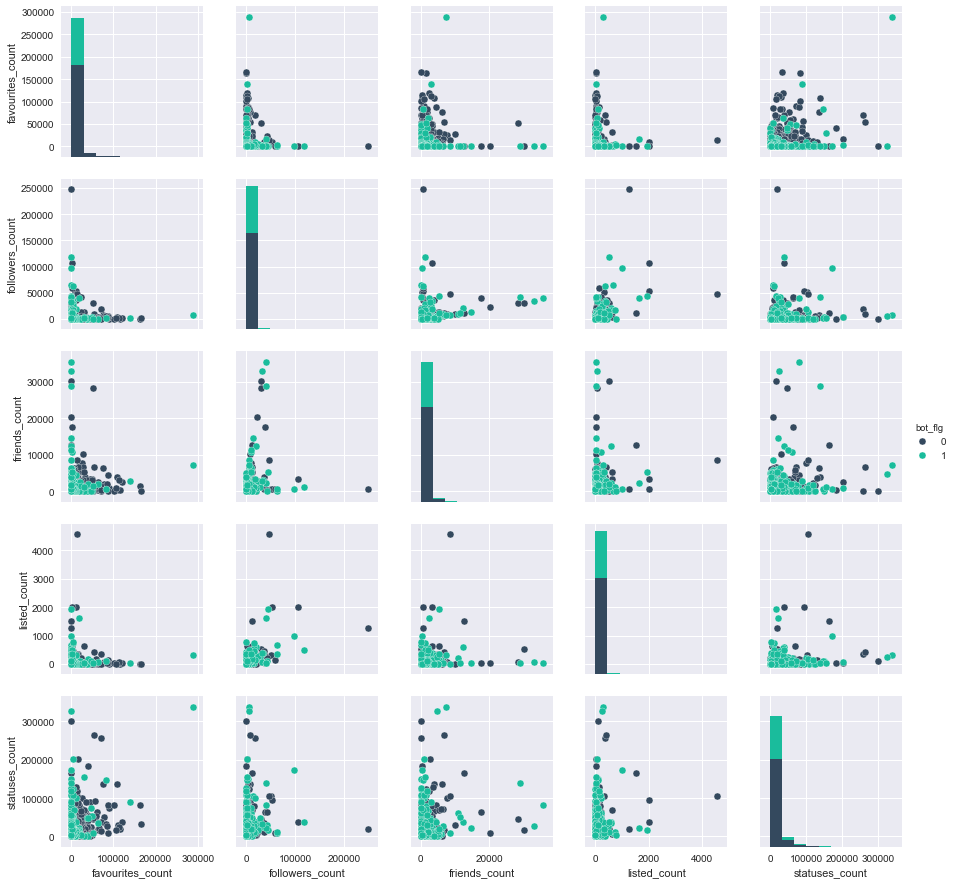

In [94]:
# Create a Matrix plot across Bot and Human classes
ax = sns.pairplot(consolidated_ftrs_df, hue="bot_flg"
                   , vars=['favourites_count', 'followers_count', 'friends_count', 'listed_count', 
                      'statuses_count'])

<div class="gc"> <b>Matrix plot of Tweet Level Entity features across Bot and Human classes</b> </div>

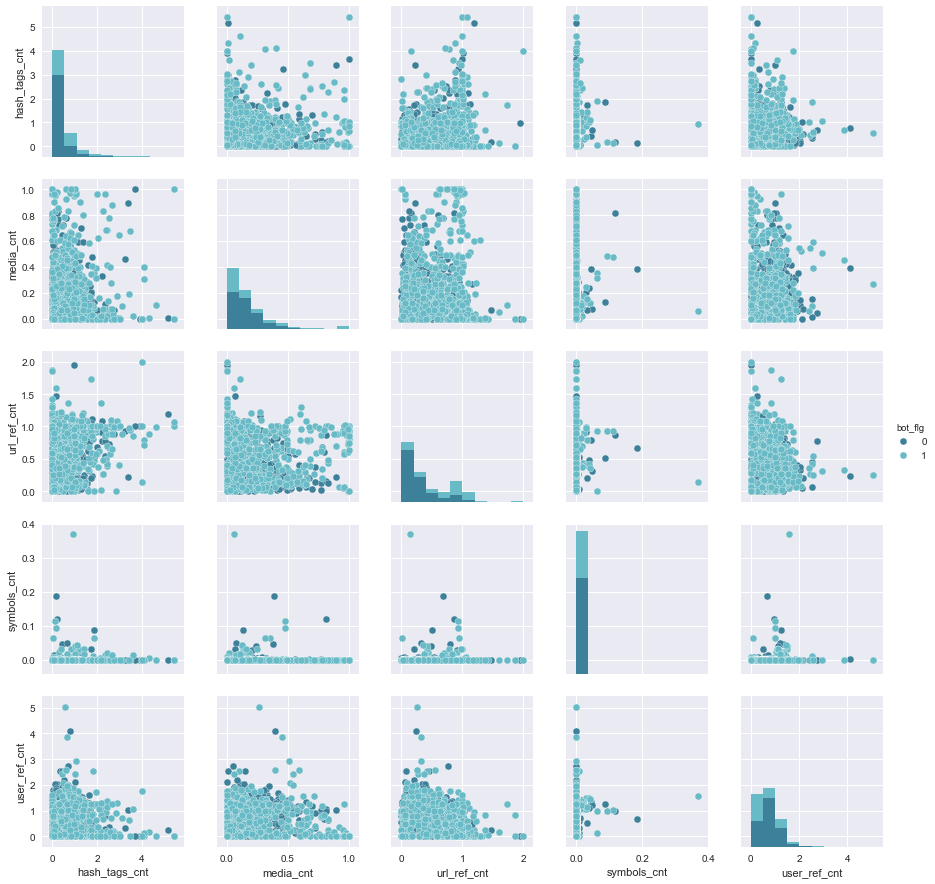

In [95]:
# Create a Matrix plot across Bot and Human classes
ax = sns.pairplot(consolidated_ftrs_df, hue="bot_flg", palette="GnBu_d"
                   , vars=['hash_tags_cnt', 'media_cnt', 'url_ref_cnt', 'symbols_cnt', 'user_ref_cnt'])

<div class="gc"> <b>Heat map of the correlation matrix for the numeric features</b> </div>

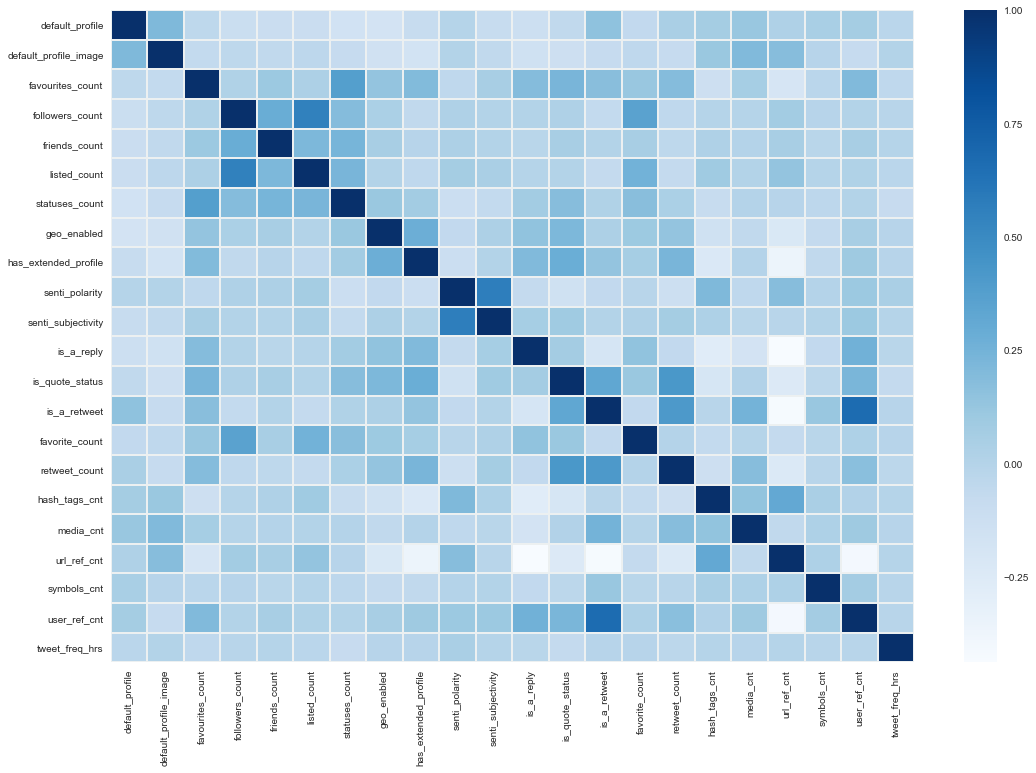

In [96]:
# Initialize the Figure
fig, ax = plt.subplots(1, 1, figsize=(18, 12))

# Calculate the correlation between the numeric features
corr = consolidated_ftrs_df.drop(['bot_flg', "user_lang", 'protected', 'verified', 'is_translator'
                                   , 'possibly_sensitive', 'place_reference','hash_tags']
                                 , axis=1, errors='ignore').corr()

# Generate a heatmap on the correlation matrix
ax = sns.heatmap(corr,cmap='Blues', linewidth=1, linecolor='#ecf0f1', ax=ax)

<div class="gc"> <b>Distribution plot of Tweet Level Entities across Bot and Human classes</b> </div>

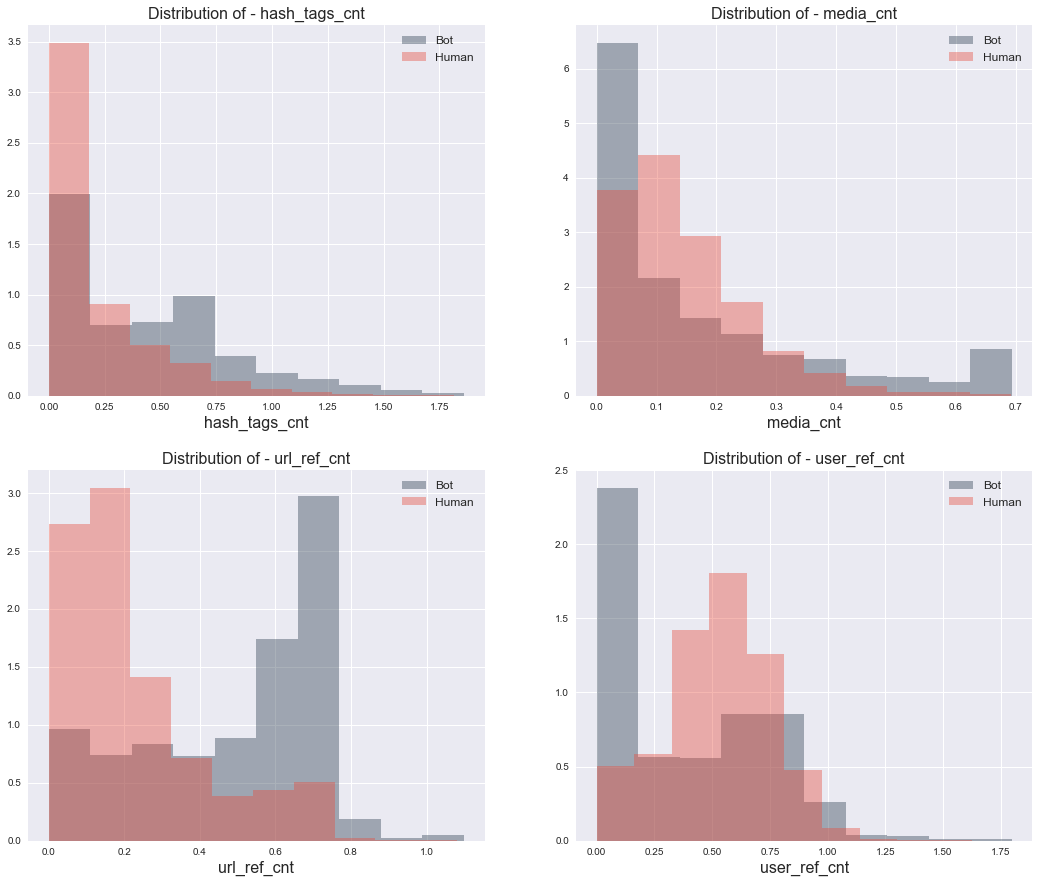

In [97]:
# Initialize the Figure with 2X2 subplots
fig, ax = plt.subplots(2, 2, figsize=(18, 15))
idx = 1

# for all entity counts, plot a overlaying histogram subplot of Bot and Human classes
for cnt in ['hash_tags_cnt', 'media_cnt', 'url_ref_cnt', 'user_ref_cnt']:
    plt.subplot(2, 2, idx)
    plt.hist(np.log(df_bot[cnt]+1), alpha=0.4, color='#2c3e50', label="Bot", density=True)
    plt.hist(np.log(df_human[cnt]+1), alpha=0.4, color='#e74c3c', label="Human", density=True)
    plt.xlabel(cnt, fontsize = 16)
    plt.title('Distribution of - ' + cnt, fontsize = 16)
    plt.legend(fontsize = 12)
    idx += 1
    
plt.show()

<div class="gc"> <b>Distribution plot of User Level Count features across Bot and Human classes</b> </div>

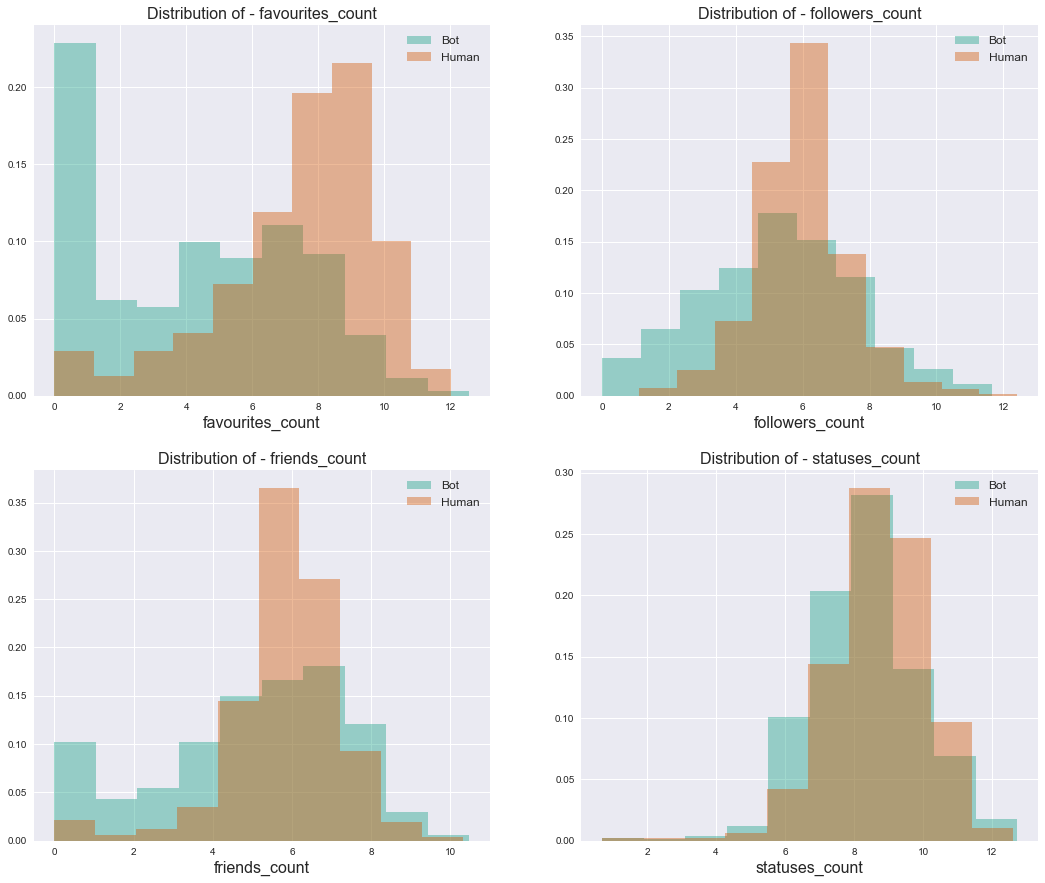

In [98]:
# Initialize the Figure with 2X2 subplots
fig, ax = plt.subplots(2, 2, figsize=(18, 15))
idx = 1

# for all user level counts, plot a overlaying histogram subplot of Bot and Human classes
for cnt in ['favourites_count', 'followers_count', 'friends_count', 'statuses_count']:
    plt.subplot(2, 2, idx)
    plt.hist(np.log(df_bot[cnt]+1), alpha=0.4, color='#16a085', label="Bot", density=True)
    plt.hist(np.log(df_human[cnt]+1), alpha=0.4, color='#d35400', label="Human", density=True)
    plt.xlabel(cnt, fontsize = 16)
    plt.title('Distribution of - ' + cnt, fontsize = 16)
    plt.legend(fontsize = 12)
    idx += 1
    
plt.show()

<div class="gc"> <b>Distribution plot of Tweet Frequency in Hours across Bot and Human classes</b> </div>

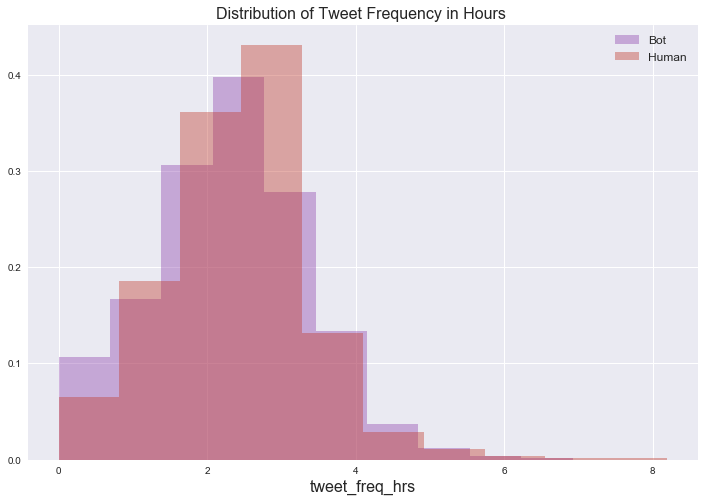

In [99]:
# Initialize the Figure with 2X2 subplots
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
idx = 1

# for tweeting frequency, plot a overlaying histogram subplot of Bot and Human classes
for cnt in ['tweet_freq_hrs']:
    plt.subplot(1, 1, idx)
    plt.hist(np.log(df_bot[cnt]+1), alpha=0.4, color='#8e44ad', label="Bot", density=True)
    plt.hist(np.log(df_human[cnt]+1), alpha=0.4, color='#c0392b', label="Human", density=True)
    plt.xlabel(cnt, fontsize = 16)
    plt.title('Distribution of Tweet Frequency in Hours ', fontsize = 16)
    plt.legend(fontsize = 12)
    idx += 1
    
plt.show()

<div class="gc"> <b>Distribution plot of Sentiment analysis scores of Tweets across Bot and Human classes</b> </div>

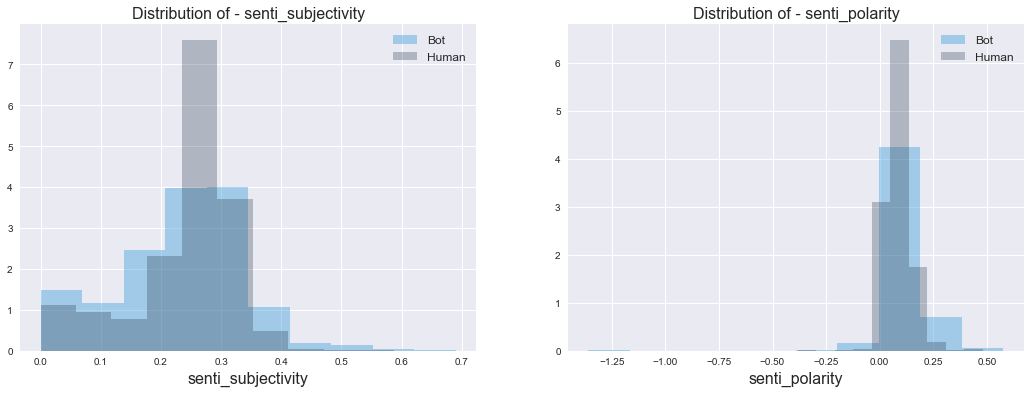

In [100]:
# Initialize the Figure with 2X2 subplots
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
idx = 1

# for sentiment analysis scores, plot a overlaying histogram subplot of Bot and Human classes
for cnt in ['senti_subjectivity', 'senti_polarity']:
    plt.subplot(1, 2, idx)
    plt.hist(np.log(df_bot[cnt]+1), alpha=0.4, color='#3498db', label="Bot", density=True)
    plt.hist(np.log(df_human[cnt]+1), alpha=0.3, color='#2c3e50', label="Human", density=True)
    plt.xlabel(cnt, fontsize = 16)
    plt.title('Distribution of - ' + cnt, fontsize = 16)
    plt.legend(fontsize = 12)
    idx += 1
    
plt.show()

<div class="gc"> <b>Distribution plot of Categorical features</b> </div>

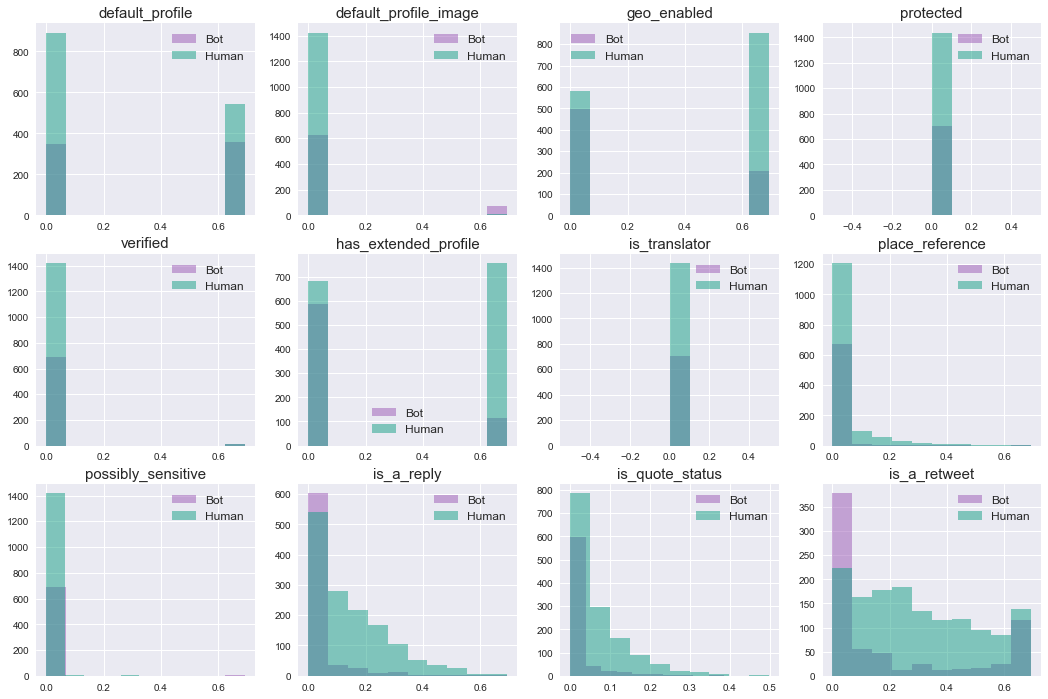

In [101]:
# Initialize the Figure with 2X2 subplots
fig, ax = plt.subplots(3, 4, figsize=(18, 12))
idx = 1

# for all categorical, plot a overlaying histogram subplot of Bot and Human classes
for cnt in ['default_profile', 'default_profile_image', 'geo_enabled', 'protected'
            , 'verified', 'has_extended_profile', 'is_translator','place_reference'
            ,'possibly_sensitive','is_a_reply', 'is_quote_status', 'is_a_retweet']:
    plt.subplot(3, 4, idx)
    plt.hist(np.log(df_bot[cnt]+1), alpha=0.5, color='#9b59b6', label="Bot")
    plt.hist(np.log(df_human[cnt]+1), alpha=0.5, color='#16a085', label="Human")
    plt.title(cnt, fontsize = 15)
    plt.legend(fontsize = 12)
    idx += 1
    
plt.show()

<div class="gc"> <b>Distribution of User Languages across User classes</b> </div>

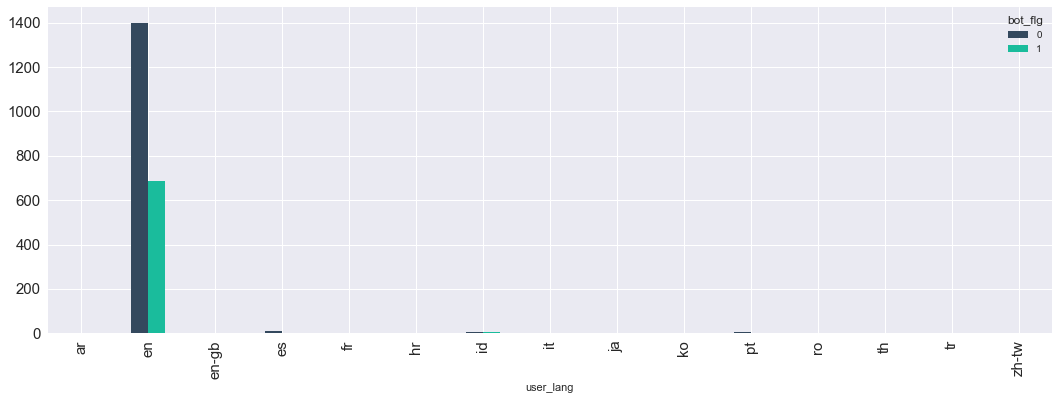

In [102]:
# Initialize the Figure
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

# for Both human and bot classes, plot a bar plot subplot of different languages used
ax = pd.crosstab(consolidated_ftrs_df.user_lang, consolidated_ftrs_df.bot_flg).plot.bar(ax=ax)


<div class="gc"> <b>Feature Importance</b> </div>
**Drop features that does not seem to differing distribution patterns between the human and bot classes in the EDA Process and thene evaluate the importance of the remaining features using Extra Trees Classifier**

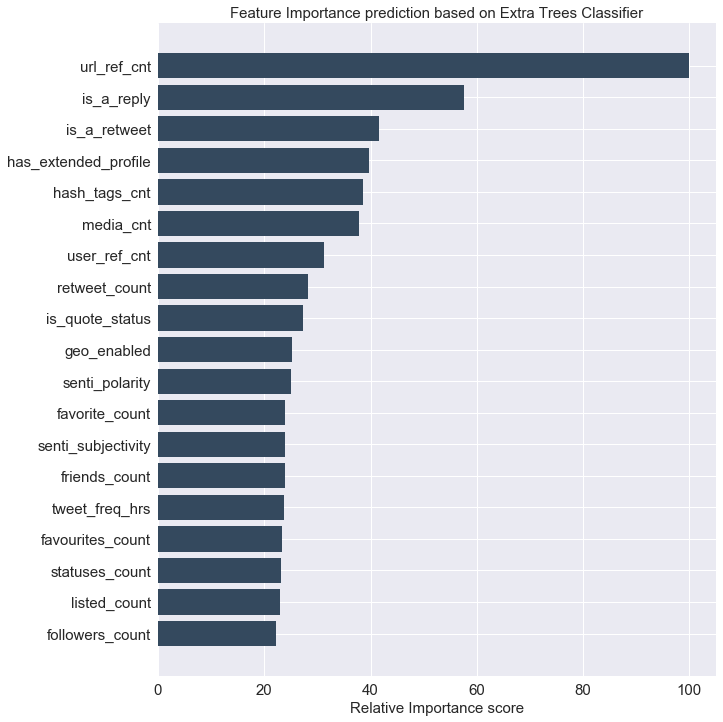

In [103]:
# Drop the categorical values that does not seem to be providing value based on EDA
processed_data_df = consolidated_ftrs_df.drop(['protected',  'verified', 'is_translator', 'default_profile_image'
                                                  , 'possibly_sensitive', 'place_reference', "user_lang"
                                               , 'default_profile', 'symbols_cnt', 'hash_tags'
                                              ], axis=1, errors='ignore')


# Instantiate an ExtraTreeClassifier model with 100 estimators and fit with the predictor data set
ext_tree_clf = ExtraTreesClassifier(n_estimators = 100)
ext_tree_clf.fit(processed_data_df.drop(["bot_flg"], axis=1), processed_data_df["bot_flg"])

# Evaluate the feature importance from the fit model
feature_importance = ext_tree_clf.feature_importances_

# Calculate relative importance score of the features and plot them in descending order of importance (High to Low)
feature_importance = 100.0 * (feature_importance / np.abs(feature_importance).max())
sorted_idx = np.argsort(np.abs(feature_importance))
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(10,12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, processed_data_df.drop(["bot_flg"], axis=1).columns[sorted_idx], fontsize=15)
plt.xlabel('Relative Importance score', fontsize=15)
plt.title('Feature Importance prediction based on Extra Trees Classifier', fontsize=15)
plt.tick_params(labelsize=15)

plt.show()

<div class="gc"> <b>Topic Based Modeling - Distribution of Hash tag topics used</b> </div>

In [104]:
# Plot the most used topics from the given set of topics
def plot_most_used_topics(topics, class_type, top_n=20):
    '''Calculate the Most used topics from the given set of topic and 
        plot the top_n topics and the number of times they have been used
       
       Args:
           topics: Dataseries containing all the topics to assess.
           class_type: Type of the user class being assessed
           top_n: count of top n features to plot. Default is 20
    '''
    
    # Extract the consolidated topics in a list as a separte topic items
    text_clean = ' '.join([text for text in topics]).split()
    text_clean = [ x for x in text_clean if x is not '1']
    
    # Use counter to count the number of times each topic is used and extract the top n used for plotting
    counts = Counter(text_clean)
    common_words = [word[0] for word in counts.most_common(top_n)]
    common_counts = [word[1] for word in counts.most_common(top_n)]

    # Plot a Bar plot for the top n topics
    fig = plt.figure(figsize=(18,6))
    sns.barplot(x=common_words, y=common_counts)
    plt.title(str(top_n) + ' Most Common topics discussed in '+ class_type + ' tweets', fontsize=15)
    plt.xticks(rotation=90)
    plt.tick_params(labelsize=15)
    plt.show()

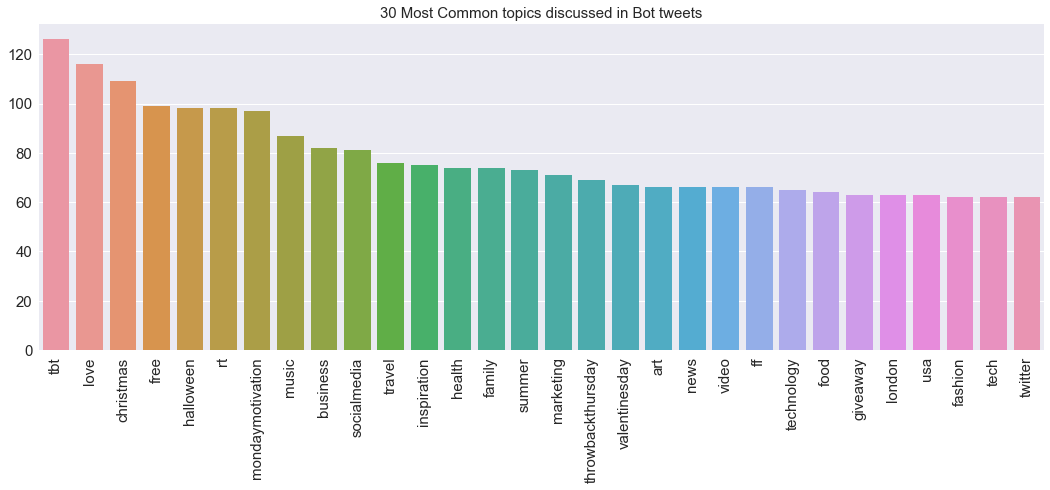

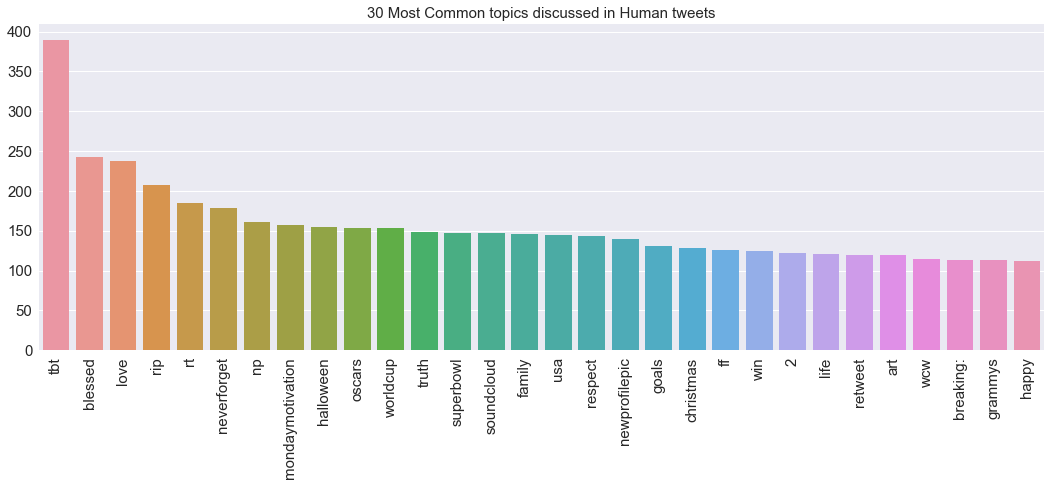

In [105]:
# Plot the top 30 Topics discussed by Bot class users from our training data set
plot_most_used_topics(df_bot['hash_tags'], 'Bot', 30)

# Plot the top 30 Topics discussed by Human class users from our training data set
plot_most_used_topics(df_human['hash_tags'], 'Human', 30)

<div class="gc"> <b>Cummulative plot of PCA variance ratio of principal features</b> </div>

Number of principal components explaining atleast 95% variance -  4


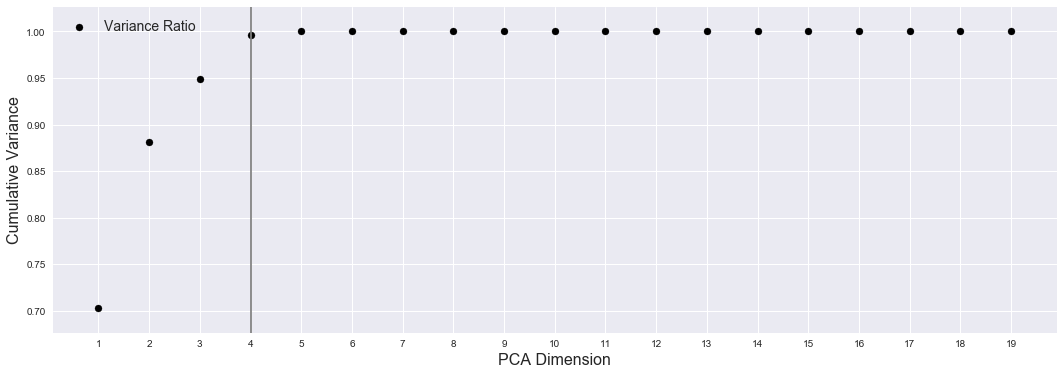

In [106]:
# Initialize PCA for 19 components and fit on the normalized training data
pca = PCA(n_components=19)
pca.fit(processed_data_df.drop(["bot_flg"], axis=1))

# Initialize a figure for the Variance plot
fig, ax = plt.subplots(figsize=(18, 6))

# Draw a scatter plot on the cumulative sum on the explained variance percentage for the principal components
ax.scatter(range(1,len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_)
           ,color='black', label='Variance Ratio')

# Define Plot Labels and legends
plt.xlabel("PCA Dimension", fontsize = 16)
plt.ylabel("Cumulative Variance", fontsize = 16)
plt.xticks(np.arange(1,len(pca.explained_variance_ratio_)+1, step=1))
plt.legend(fontsize = 14);

# Determine the number of principal components at which 95% variance is explained
comp_count = 0
cum_sum = 0
for ratio in pca.explained_variance_ratio_:
    comp_count += 1
    cum_sum += ratio
    if cum_sum >= 0.95 :
        break

# Draw a vertical axis line to indicate the optimal number of principal components
plt.axvline(comp_count, color='.5')
print('Number of principal components explaining atleast 95% variance - ', comp_count)
        
plt.show()

<h2>Dataset splitting, One-hot encoding of categorical features, Scaling and Normalization</h2>

**Scale and Normalize data attributes to follow an uniform scaling for proper weightage of features by the model**   
**Perform One-hot encoding for category based features**

In [107]:
# Perform One Hot Encoding to add dummy columns for categorical values of User Language feature
# processed_data_df=pd.get_dummies(processed_data_df, columns=['user_lang'], drop_first=True)

In [108]:
# Method Implementation to Separate the X (Predictor) and y (Response) variables in a data set
def separate_X_and_y(data, outcome_col_name='bot_flg'):
    '''Separate the predictor variables and outcome variable to separate dataframes
       
       Args:
           data: Dataframe containing predictor and Response variables.
           outcome_col_name: Name of the response column to extract
       Returns:
           X_df: Normalized predictor features of Training data set.
           y_df: Outcome variable list of Training data set.
    '''
    # Separate Predictor and Response variables in dataset
    X_df = data.drop([outcome_col_name], axis=1)
    y_df = data[outcome_col_name]
    
    # Reset Index of data set for consistency
    X_df = X_df.reset_index(drop=True)
    y_df = y_df.reset_index(drop=True)
    
    return X_df, y_df

# Method Implementation to split data to train and test data set and scale predictor features
def split_train_and_test(data, outcome_col_name='bot_flg', scale_type='MinMax', split_ratio=0.2):
    '''Split the data into train and test data set and scale them
       
       Args:
           data: Dataframe containing predictor and Response variables.
           outcome_col_name: Name of the response column to extract
           Scale_type: Type of scaling to perform 'MinMax' or 'Standard'
           split_ratio: Ratio of data to split in training and test data set
       Returns:
           X_train_scale: Scaled predictor features of Training data set.
           y_train: Outcome variable list of Training data set.
           X_val_scale: Scaled predictor features of Test data set.
           y_val: Outcome variable list of Test data set.
    '''
    
    # Make a 80-20 Split of the data to get training and test data
    data_train, data_test = train_test_split(data, random_state=90, test_size=split_ratio
                                             , stratify=data[outcome_col_name]) 
            
    # Separate Predictor and Response variables in Training and Test dataset
    X_train, y_train = separate_X_and_y(data_train, outcome_col_name)
    X_val, y_val = separate_X_and_y(data_test, outcome_col_name)

    # Check scale_type and use appropriate scaler
    if scale_type == 'MinMax':
        # Initialize a Min Max scaler to normalize all predcitor variables between 0 and 1
        scaler = MinMaxScaler()
    else:
        # Initialize a Standard scaler to scale all predcitor variables based on mean and std
        scaler = StandardScaler()

    # Fit scaler based on Training data
    scaler.fit(X_train.values)

    # Transform to Normalize Training data set
    X_train_scaled = scaler.transform(X_train.values)
    X_train_scale = pd.DataFrame(X_train_scaled)
    X_train_scale.columns = list(X_train)

    # Transform to Normalize Test data set
    X_val_scaled = scaler.transform(X_val.values)
    X_val_scale = pd.DataFrame(X_val_scaled)
    X_val_scale.columns = list(X_val)
        
    return X_train_scale, y_train, X_val_scale, y_val

In [109]:
X_train_scale, y_train, X_val_scale, y_val = split_train_and_test(processed_data_df)

# <img style="float: left; padding-right: 10px; width: 55px" src="assets/ml.png"> Model Training and Validation 

**Creation, Training and Validation of classification models**

In [110]:
# Dictionary of Models to compare
models_to_compare = {}
acc_stats_table_data = {}

TRAIN = 'Train'
VALIDATION = 'Validation'
TEST = 'Test'

**Utility Method for gathering model accuracy and model comparisons**

In [184]:
# Method implementation to calculate classifier prediction accuracy and CV scores
def get_classifier_accuracy(model, X_data, y_data, model_title, data_type=TRAIN, cv_fold=10, print_stats=True):
    ''' Calculate the Accuracy and Mean Cross validation score of the model
        Add the model to the comparison Dictionary
        
       Args:
           model The classifier model used to fit and predict the classifiers
           X_data: Dataframe containing the predictor variables.
           y_data: Dataframe containing the outcome variable.
           model_title: Title of the model to use for reporting
           data_type: Type of data being plotted (Train/Validation/Test). Default value is Train
           cv_fold: Cross Validation Fold used. Default value is 5
           print_stats: Flag to indicate if accuracy stats must be printed. Default is True
        Return:
           accuracy: Prediction accuracy Score of the model
           cv_scores: Cross validation scores of the model
    '''
    
    # Add to the model list to compare
    models_to_compare[model_title] = model

    # Generate predictions for the given data set
    predictions = np.round(model.predict(X_data))
    
    accuracy = accuracy_score(y_data, predictions)
    # Report stats only when print flag is set to True
    if print_stats == True:
        print("%s Model - (%s) Prediction Accuracy: %0.2f" % (model_title, data_type, accuracy))
    
    cv_mean = 0
    cv_std = 0
    cv_scores = None
    # Check if the model has a score method before CV validation
    if hasattr(model, 'score') and data_type==TRAIN:
        # Calculate Cross validation accuracy score of the model using x fold cross validation
        cv_scores = cross_val_score(model, X_data, y_data, cv=cv_fold)
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
        
        if print_stats == True:
            print("%s (%s) Cross Validation accuracy and 95 percent CI: %0.2f (+/- %0.2f)" 
                      % (model_title, data_type, cv_mean, cv_std * 2))

        # Plot the prediction accuracy and cross validation scores for cv_fold iterations
        fig = plt.figure(figsize=(12,4))
        plt.plot(range(1,cv_fold+1), cv_scores, marker= 'o', c = '#c0392b', label='CV Scores', linewidth=1)
        plt.fill_between(range(1,cv_fold+1), [cv_mean + (2* cv_std)] * cv_fold ,[cv_mean - (2* cv_std)] * cv_fold
                         , color = '#1abc9c', alpha=0.2, label='+/- 2 SDev of CV mean')
        plt.axhline(accuracy, c = '#2c3e50', label='Accuracy Score', linewidth=2)

        # Set title, axis values and legends for the plot
        bot = 0.7
        if cv_scores.min() < 0.75:
            bot = cv_scores.min()-0.05
        plt.title(model_title +' - Prediction accuracy and CV scores for each fold - ' + data_type, fontsize = 15)
        plt.xlabel('CV fold iterations', fontsize = 15)
        plt.ylabel('Score', fontsize = 15)
        plt.ylim(bottom=bot, top=1)

        plt.xlim(left=1, right=cv_fold)
        plt.legend(fontsize = 15)
        plt.show()
    else:
        cv_mean = accuracy

        
    # Add accuracy stats to the stats table
    type_stats = acc_stats_table_data.get(data_type, {});
    if model_title != 'Topic Model':
        if data_type==TRAIN:
            type_stats[model_title] = [model_title, round(accuracy,3), round(cv_mean,3)
                                       , round(cv_std*2,2), confusion_matrix(y_data, predictions).ravel()]
        else:
            type_stats[model_title] = [model_title, round(accuracy,3), confusion_matrix(y_data, predictions).ravel()]
    
        acc_stats_table_data[data_type] = type_stats;
        
    return accuracy, cv_scores

# Render the Accuracy stats of Model in tabular format
def renderAccuracyStatsIable(stats_table_data, data_type, plot_type='CV Accuracy'):
    ''' Method to Render the Accuracy stats of Model in tabular format
        
       Args:
           stats_table_data: List of Lists containing model accuracy stats in a tabular format
           data_type: Type of the data for which the status has been gathered for (TRAIN/VALIDATION/TEST)
           plot_type: Type of score to be used to render the bar plots. Default is 'CV Accuracy'
    '''
    type_stats = stats_table_data.get(data_type, {});
    
    # Title of Column Labels to report Accuracy
    if data_type==TRAIN:
        colLabels = ['Model Title', 'Prediction Accuracy', 'CV Accuracy', '95% CI (+/-)', 'TN, FP, FN, TP']
    else:
        colLabels = ['Model Title', 'Prediction Accuracy', 'TN, FP, FN, TP']
        plot_type='Prediction Accuracy'

    print('** %s ** Comparison Table of Accuracy stats for different classifiation models' % (data_type))
    # Render the Stats of different models in a table for better comparability
    fig = plt.figure(figsize=(18,5))
    ax = plt.subplot(111, frame_on=False) 
    
    # Do some data prep for table
    models = []
    cv_scrs = []
    acc_scrs = []
    table_data = []
    for key, val in type_stats.items():
        models.append(val[0])
        acc_scrs.append(val[1])
        cv_scrs.append(val[2])
        table_data.append(val)

    tbl = plt.table(cellText=table_data, colLabels=colLabels,loc='top')
    tbl.set_fontsize(16)
    tbl.scale(1, 4)
    
    # Set colors for the bar plots
    bar_color = '#16a085'
    high_color = '#e67e22'
    if data_type == TEST:
        bar_color = '#2980b9'
        high_color = '#34495e'
    
    ylabel = 'Cross Validation Score'   
    bar_scrs = cv_scrs
    if plot_type != 'CV Accuracy':
        ylabel = 'Prediction Accuracy Score'   
        bar_scrs = acc_scrs
    
    # Render a bar chart of the model accuracy scores
    ax.set_ylim(bottom=min(bar_scrs)-0.05, top= max(max(bar_scrs),1))
    y_pos = np.arange(len(models))
    barlist = plt.bar(y_pos, bar_scrs, align='center', color=bar_color)
    barlist[bar_scrs.index(max(bar_scrs))].set_color(high_color)
    plt.xticks(y_pos, models)
    plt.ylabel(ylabel)
    plt.title('Classification Model')
    
    plt.show()

<h2>Trivial Classification - Baseline Model</h2>

In [112]:
# Implement a trivial model that predicts Human class (0) for any input
def predict_trivial(X): 
    return np.zeros(len(X))

# Make trivial predictions on the train data set and calculate scores
trivial_predictions = predict_trivial(X_train_scale)
baseline_accuracy = accuracy_score(y_train, trivial_predictions)
print("Baseline Accuracy from Trivial Model:" + str(round(baseline_accuracy, 2)))

Baseline Accuracy from Trivial Model:0.67


<h2>Logistic Regression CV</h2>

Logistic CV Model - (Train) Prediction Accuracy: 0.81
Logistic CV (Train) Cross Validation accuracy and 95 percent CI: 0.81 (+/- 0.05)


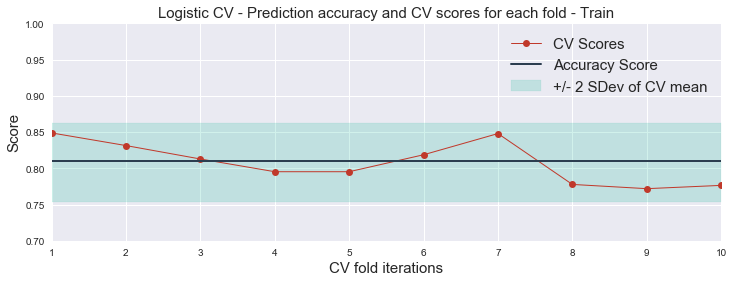

Logistic CV Model - (Validation) Prediction Accuracy: 0.83


In [113]:
LOGISTIC_CLF = 'Logistic CV' # Model Title constant for Logistic Classifier

# Initialize a Logistic CV Regression model with L2 regualarization
lcv_clf = LogisticRegressionCV(cv=5, penalty='l2', max_iter=1000, multi_class = 'ovr')

# Fit the model with the training set data
lcv_clf.fit(X_train_scale, y_train)

# Report Prediction accuracy on Train and Validation Data sets
lcv_train_acc, lcv_train_cv = get_classifier_accuracy(lcv_clf, X_train_scale, y_train, LOGISTIC_CLF , TRAIN)
lcv_val_acc, lcv_val_cv = get_classifier_accuracy(lcv_clf, X_val_scale, y_val, LOGISTIC_CLF, VALIDATION)

<h2>Principal Component Analysis (PCA) Classifier</h2>

PCA Model - (Train) Prediction Accuracy: 0.80
PCA (Train) Cross Validation accuracy and 95 percent CI: 0.80 (+/- 0.06)


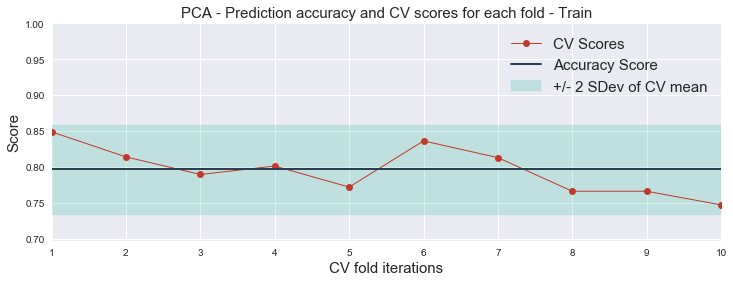

PCA Model - (Validation) Prediction Accuracy: 0.82


In [114]:
PCA_CLF = 'PCA' # Model Title constant for PCA Classifier

# Initialize a PCA instnace for 4 principal components and fit using the scaled training data
pca = PCA(n_components=comp_count)
pca.fit(X_train_scale)

# Transform the scaled training and test data set using the fitted PCA model
X_train_pca_4 = pca.transform(X_train_scale)
X_val_pca_4 = pca.transform(X_val_scale)

# Instantiate a Logisitic classification model for the data set transformed with 3 principal components
#pca_3_clf = LogisticRegressionCV(cv=5, penalty='l2', max_iter=1000, multi_class = 'ovr')
pca_4_clf = LogisticRegression(C=1000000, solver='newton-cg', max_iter=250)

# Fit the model with the training set data
pca_4_clf.fit(X_train_pca_4, y_train)

# Report Prediction accuracy on Train and Validation Data sets
pca_4_train_acc, pca_4_train_cv = get_classifier_accuracy(pca_4_clf, X_train_pca_4, y_train, PCA_CLF, TRAIN)
pca_4_val_acc, pca_4_val_cv = get_classifier_accuracy(pca_4_clf, X_val_pca_4, y_val, PCA_CLF, VALIDATION)

<h2>Linear Discriminant Analysis (LDA) Classifier</h2>

LDA Model - (Train) Prediction Accuracy: 0.81
LDA (Train) Cross Validation accuracy and 95 percent CI: 0.80 (+/- 0.05)


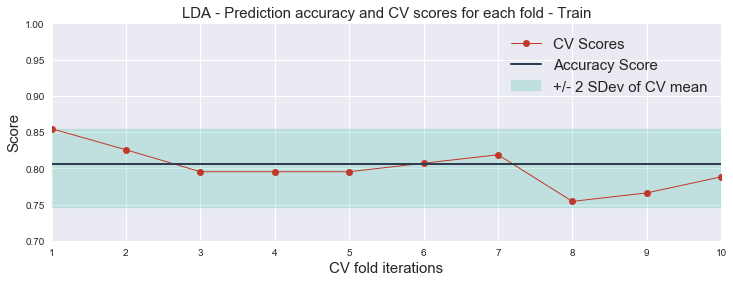

LDA Model - (Validation) Prediction Accuracy: 0.82


In [115]:
LDA_CLF = 'LDA' # Model Title constant for LDA Classifier

# Initialize a LDA Model
lda = LinearDiscriminantAnalysis()

# Fit the model with the training set data
lda.fit(X_train_scale, y_train)

# Report Prediction accuracy on Train and Validation Data sets
lda_train_acc, lda_train_cv = get_classifier_accuracy(lda, X_train_scale, y_train, LDA_CLF, TRAIN)
lda_val_acc, lda_val_cv = get_classifier_accuracy(lda, X_val_scale, y_val, LDA_CLF, VALIDATION)

<h2>Quadratic Discriminant Analysis (QDA) Classifier</h2>

QDA Model - (Train) Prediction Accuracy: 0.77
QDA (Train) Cross Validation accuracy and 95 percent CI: 0.76 (+/- 0.08)


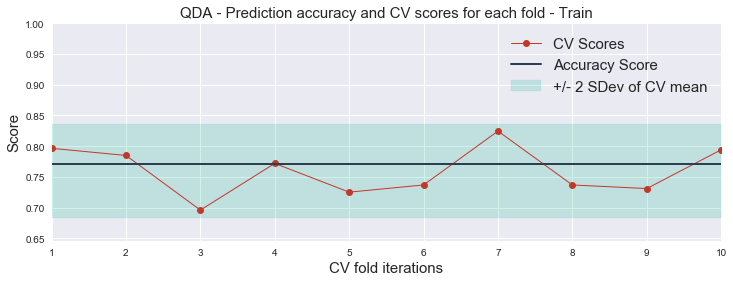

QDA Model - (Validation) Prediction Accuracy: 0.80


In [116]:
QDA_CLF = 'QDA' # Model Title constant for QDA Classifier

# Initialize a LDA Model
qda = QuadraticDiscriminantAnalysis()

# Fit the model with the training set data
qda.fit(X_train_scale, y_train)

# Report Prediction accuracy on Train and Validation Data sets
qda_train_acc, qda_train_cv = get_classifier_accuracy(qda, X_train_scale, y_train, QDA_CLF, TRAIN)
qda_val_acc, qda_val_cv = get_classifier_accuracy(qda, X_val_scale, y_val, QDA_CLF, VALIDATION)

<h2>k-Nearest-Neighbors Classifier</h2>

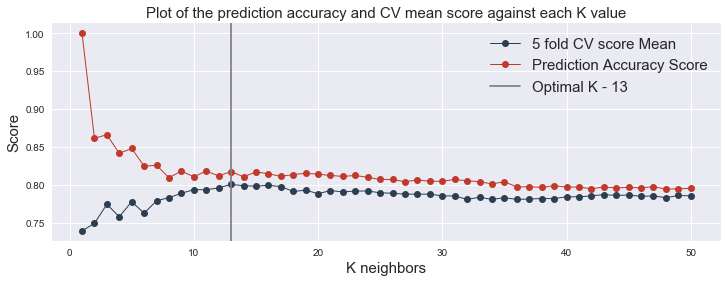

In [117]:
# Instantiate lists to hold accuracy and fitted model per k-value
knn_accuracy = []
knn_cv_means = []
knn_models = {}

max_cv_mean = 0
optimal_k = 0
max_k = 51
# Loop from k neighbors from 1 to max K
for k in range(1,max_k):
    #Instantiate a kNN classifier for k neighbors
    knn_clf = KNeighborsClassifier(n_neighbors=k)
    
    # Fit for the training data    
    knn_clf.fit(X_train_scale, y_train)
        
    # Check accuracy using prediction on the training data
    predictions = knn_clf.predict(X_train_scale)
    acc_score = accuracy_score(y_train, predictions)
    knn_accuracy.append(acc_score)
       
    # Check accuracy for 5-fold cross validation test and take the mean
    cv_mean = cross_val_score(knn_clf, X_train_scale, y_train, cv=5).mean()
    knn_cv_means.append(cv_mean)
    knn_models[k] = knn_clf
    
    # update K with max CV Mean score
    if cv_mean > max_cv_mean:
        max_cv_mean = cv_mean
        optimal_k = k

# Plot the prediction accuracy andf 5 fold cross validation mean for each tree depth
fig = plt.figure(figsize=(12,4))
plt.plot(range(1,max_k), knn_cv_means,marker= 'o', c = '#2c3e50', label='5 fold CV score Mean', linewidth=1)
plt.plot(range(1,max_k), knn_accuracy,marker= 'o', c = '#c0392b', label='Prediction Accuracy Score', linewidth=1)
plt.axvline(optimal_k, color='.5', label='Optimal K - ' + str(optimal_k))

# Set title, axis values and legends for the plot
plt.title('Plot of the prediction accuracy and CV mean score against each K value', fontsize = 15)
plt.xlabel('K neighbors', fontsize = 15)
plt.ylabel('Score', fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

kNN, K-13 Model - (Train) Prediction Accuracy: 0.82
kNN, K-13 (Train) Cross Validation accuracy and 95 percent CI: 0.80 (+/- 0.06)


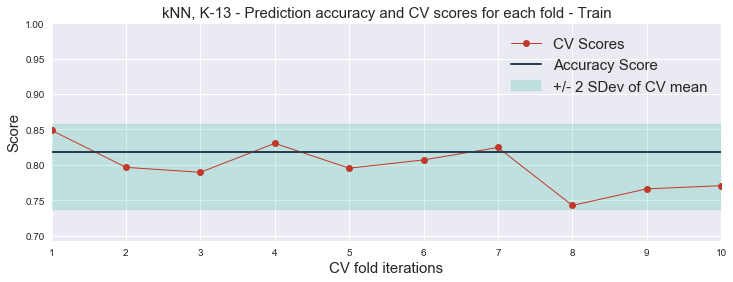

kNN, K-13 Model - (Validation) Prediction Accuracy: 0.82


In [118]:
KNN_CLF = 'kNN, K-'+str(optimal_k) # Model Title constant for kNN Classifier

# Report Prediction accuracy on Train and Validation Data sets
knn_train_acc, knn_train_cv = get_classifier_accuracy(knn_models[optimal_k], X_train_scale, y_train, KNN_CLF, TRAIN)
knn_val_acc, knn_val_cv = get_classifier_accuracy(knn_models[optimal_k], X_val_scale, y_val, KNN_CLF, VALIDATION)

<h2>Decision Tree Classifier</h2>

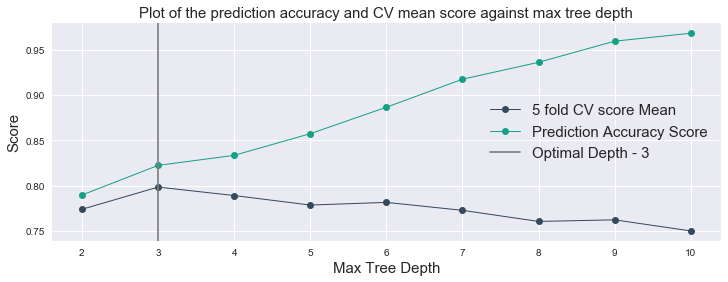

In [119]:
# Instantiate lists to hold tree depths, accuracy and fitted model per depth
tree_depths=[]
accuracy = []
cv_means = []
tree_models = {}

optimal_depth = 0
max_cv_mean = 0
# Loop from tree depth 2 to 10
for depth in range(2,11):
    #Instantiate a Decision Tree classifier for the current depth using gini index as the criterion
    dt_clf = DecisionTreeClassifier(criterion='gini',max_depth=depth)
    
    # Fit for the training data    
    dt_clf.fit(X_train_scale, y_train)
        
    # Check accuracy using prediction on the training data
    predictions = dt_clf.predict(X_train_scale)
    acc_score = accuracy_score(y_train, predictions)
    accuracy.append(acc_score)
    
    # Check accuracy for 5-fold cross validation test and take the mean
    cv_mean = cross_val_score(dt_clf, X_train_scale, y_train, cv=5).mean()
    cv_means.append(cv_mean)
    tree_depths.append(depth)
    tree_models[depth] = dt_clf

    # update K with max CV Mean score
    if cv_mean > max_cv_mean:
        max_cv_mean = cv_mean
        optimal_depth = depth
    
# Plot the prediction accuracy andf 5 fold cross validation mean for each tree depth
fig = plt.figure(figsize=(12,4))
plt.plot(tree_depths, cv_means,marker= 'o', c = '#34495e', label='5 fold CV score Mean', linewidth=1)
plt.plot(tree_depths, accuracy,marker= 'o', c = '#16a085', label='Prediction Accuracy Score', linewidth=1)
plt.axvline(optimal_depth, color='.5', label='Optimal Depth - ' + str(optimal_depth))

# Set title, axis values and legends for the plot
plt.title('Plot of the prediction accuracy and CV mean score against max tree depth', fontsize = 15)
plt.xlabel('Max Tree Depth', fontsize = 15)
plt.ylabel('Score', fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

Decision Tree, Depth-3 Model - (Train) Prediction Accuracy: 0.82
Decision Tree, Depth-3 (Train) Cross Validation accuracy and 95 percent CI: 0.80 (+/- 0.06)


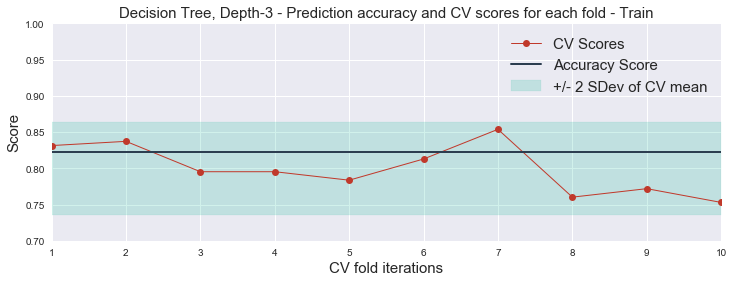

Decision Tree, Depth-3 Model - (Validation) Prediction Accuracy: 0.79


In [121]:
DT_CLF = 'Decision Tree, Depth-'+str(optimal_depth) # Model Title constant for Decision Tree Classifier

# Report Prediction accuracy on Train and Validation Data sets
dt_train_acc, dt_train_cv = get_classifier_accuracy(tree_models[optimal_depth], X_train_scale, y_train, DT_CLF, TRAIN)
dt_val_acc, dt_val_cv = get_classifier_accuracy(tree_models[optimal_depth], X_val_scale, y_val, DT_CLF, VALIDATION)

<h2>Gradient Boost Classifier</h2>

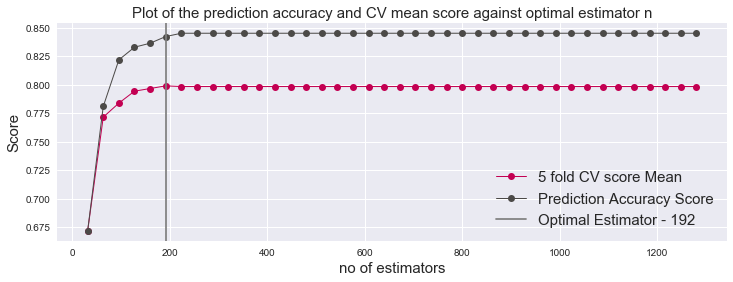

In [122]:
# Instantiate lists to hold estimator counts, accuracy and fitted model per estimator
gb_estimators=[]
accuracy = []
cv_means = []
gb_models = {}

optimal_gb_estimator = 0
max_cv_mean = 0

# Loop from estimator 1*32 to 40*32
for idx in range(1,41):
    est = 32*idx

    # Instantiate a Gradient Boosting classifier for the optimal depth using tol of 0.01
    gb_clf = GradientBoostingClassifier(n_estimators= est, validation_fraction=0.2, learning_rate=0.01
                                        , n_iter_no_change=5, tol=0.001,random_state=0)
    
    # Fit for the training data    
    gb_clf.fit(X_train_scale, y_train)
        
    # Check accuracy using prediction on the training data
    predictions = gb_clf.predict(X_train_scale)
    acc_score = accuracy_score(y_train, predictions)
    accuracy.append(acc_score)
    
    # Check accuracy for 5-fold cross validation test and take the mean
    cv_mean = cross_val_score(gb_clf, X_train_scale, y_train, cv=5).mean()
    cv_means.append(cv_mean)
    gb_estimators.append(est)
    gb_models[est] = gb_clf

    # update estimator with max CV Mean score if current score is atleast 0.001 greater than previous max
    if cv_mean > max_cv_mean +0.001:
        max_cv_mean = cv_mean
        optimal_gb_estimator = est
    
# Plot the prediction accuracy andf 5 fold cross validation mean for each tree depth
fig = plt.figure(figsize=(12,4))
plt.plot(gb_estimators, cv_means,marker= 'o', c = '#C30052', label='5 fold CV score Mean', linewidth=1)
plt.plot(gb_estimators, accuracy,marker= 'o', c = '#4C4A48', label='Prediction Accuracy Score', linewidth=1)
plt.axvline(optimal_gb_estimator, color='.5', label='Optimal Estimator - ' + str(optimal_gb_estimator))

# Set title, axis values and legends for the plot
plt.title('Plot of the prediction accuracy and CV mean score against optimal estimator n', fontsize = 15)
plt.xlabel('no of estimators', fontsize = 15)
plt.ylabel('Score', fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

Gradient Boost Model - (Train) Prediction Accuracy: 0.84
Gradient Boost (Train) Cross Validation accuracy and 95 percent CI: 0.81 (+/- 0.07)


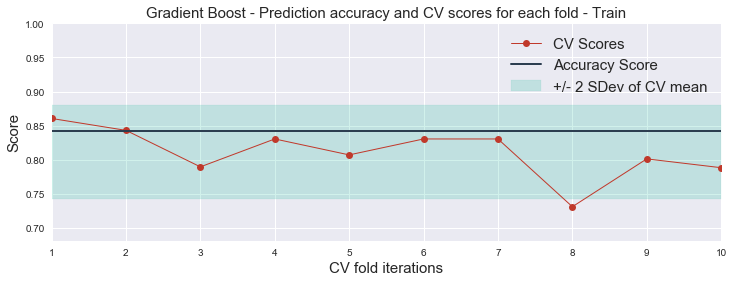

Gradient Boost Model - (Validation) Prediction Accuracy: 0.80


In [123]:
GRAD_BOOST_CLF = 'Gradient Boost' # Model Title constant for Gradient Boost Classifier

# Report Prediction accuracy on Train and Validation Data sets
gb_train_acc, gb_train_cv = get_classifier_accuracy(gb_models[optimal_gb_estimator]
                                                    , X_train_scale, y_train, GRAD_BOOST_CLF, TRAIN)
gb_val_acc, gb_val_cv = get_classifier_accuracy(gb_models[optimal_gb_estimator]
                                                , X_val_scale, y_val, GRAD_BOOST_CLF, VALIDATION)

<h2>Random Forest Classifier</h2>

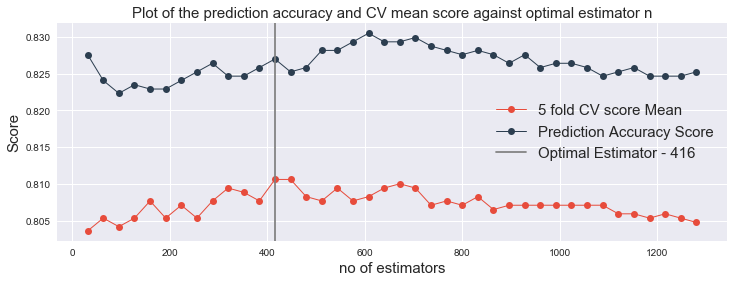

In [124]:
# Instantiate lists to hold estimator counts, accuracy and fitted model per estimator
rf_estimators=[]
accuracy = []
cv_means = []
rf_models = {}

optimal_rf_estimator = 0
max_cv_mean = 0

# Loop from estimator 1*32 to 40*32
for idx in range(1,41):
    est = 32*idx
    #est = 2**idx
    #Instantiate a Decision Tree classifier for the optimal depth using gini index as the criterion
    rf_clf = RandomForestClassifier(n_estimators= est, max_depth=optimal_depth, criterion='gini',random_state=0)
    
    # Fit for the training data    
    rf_clf.fit(X_train_scale, y_train)
        
    # Check accuracy using prediction on the training data
    predictions = rf_clf.predict(X_train_scale)
    acc_score = accuracy_score(y_train, predictions)
    accuracy.append(acc_score)
    
    # Check accuracy for 5-fold cross validation test and take the mean
    cv_mean = cross_val_score(rf_clf, X_train_scale, y_train, cv=5).mean()
    cv_means.append(cv_mean)
    rf_estimators.append(est)
    rf_models[est] = rf_clf

    # update estimator with max CV Mean score if current score is atleast 0.001 greater than previous max
    if cv_mean > max_cv_mean +0.001:
        max_cv_mean = cv_mean
        optimal_rf_estimator = est
    
# Plot the prediction accuracy andf 5 fold cross validation mean for each tree depth
fig = plt.figure(figsize=(12,4))
plt.plot(rf_estimators, cv_means,marker= 'o', c = '#e74c3c', label='5 fold CV score Mean', linewidth=1)
plt.plot(rf_estimators, accuracy,marker= 'o', c = '#2c3e50', label='Prediction Accuracy Score', linewidth=1)
plt.axvline(optimal_rf_estimator, color='.5', label='Optimal Estimator - ' + str(optimal_rf_estimator))

# Set title, axis values and legends for the plot
plt.title('Plot of the prediction accuracy and CV mean score against optimal estimator n', fontsize = 15)
plt.xlabel('no of estimators', fontsize = 15)
plt.ylabel('Score', fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

Random Forest Model - (Train) Prediction Accuracy: 0.83
Random Forest (Train) Cross Validation accuracy and 95 percent CI: 0.81 (+/- 0.07)


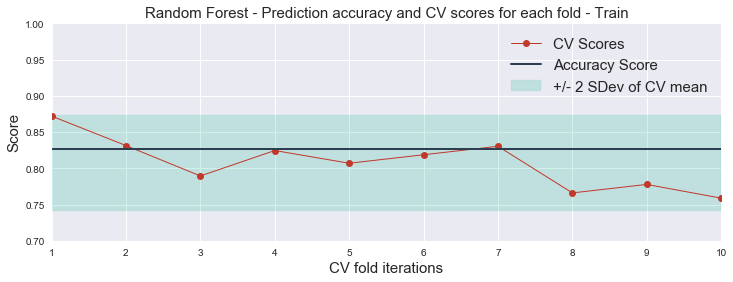

Random Forest Model - (Validation) Prediction Accuracy: 0.81


In [125]:
RAND_FOREST_CLF = 'Random Forest' # Model Title constant for Random Forest Classifier

# Report Prediction accuracy on Train and Validation Data sets
rf_train_acc, rf_train_cv = get_classifier_accuracy(rf_models[optimal_rf_estimator]
                                                    , X_train_scale, y_train, RAND_FOREST_CLF, TRAIN)
rf_val_acc, rf_val_cv = get_classifier_accuracy(rf_models[optimal_rf_estimator]
                                                , X_val_scale, y_val, RAND_FOREST_CLF, VALIDATION)

<h2>Boosting Adaboost Classifier</h2>

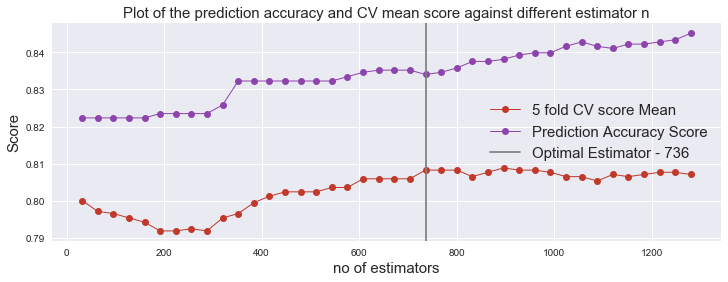

In [126]:
# Instantiate lists to hold estimator counts, accuracy and fitted model per estimator
boost_estimators=[]
accuracy = []
cv_means = []
boost_models = {}

optimal_boost_estimator = 0
max_cv_mean = 0
# Loop from estimator 1*32 to 40*32
for idx in range(1,41):
    est = 32*idx
    
    # Initialize a base learner decision tree with provided optimal depth
    base_clf = DecisionTreeClassifier(max_depth=optimal_depth)

    # Initialize a ADA boost classifier using the base DT and provided hyper params
    ada_boost_clf = AdaBoostClassifier(base_estimator=base_clf,n_estimators=est, learning_rate=0.001)

    # Train the classifier using the train data set
    ada_boost_clf.fit(X_train_scale, y_train)
        
    # Check accuracy using prediction on the training data
    predictions = ada_boost_clf.predict(X_train_scale)
    acc_score = accuracy_score(y_train, predictions)
    accuracy.append(acc_score)
    
    # Check accuracy for 5-fold cross validation test and take the mean
    cv_mean = cross_val_score(ada_boost_clf, X_train_scale, y_train, cv=5).mean()
    cv_means.append(cv_mean)
    boost_estimators.append(est)
    boost_models[est] = ada_boost_clf
    
    # update estimator with max CV Mean score if current score is atleast 0.001 greater than previous max
    if cv_mean > max_cv_mean +0.001:
        max_cv_mean = cv_mean
        optimal_boost_estimator = est
        
# Plot the prediction accuracy andf 5 fold cross validation mean for each tree depth
fig = plt.figure(figsize=(12,4))
plt.plot(boost_estimators, cv_means,marker= 'o', c = '#c0392b', label='5 fold CV score Mean', linewidth=1)
plt.plot(boost_estimators, accuracy,marker= 'o', c = '#8e44ad', label='Prediction Accuracy Score', linewidth=1)
plt.axvline(optimal_boost_estimator, color='.5', label='Optimal Estimator - ' + str(optimal_boost_estimator))

# Set title, axis values and legends for the plot
plt.title('Plot of the prediction accuracy and CV mean score against different estimator n', fontsize = 15)
plt.xlabel('no of estimators', fontsize = 15)
plt.ylabel('Score', fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

Ada Boost Model - (Train) Prediction Accuracy: 0.83
Ada Boost (Train) Cross Validation accuracy and 95 percent CI: 0.81 (+/- 0.07)


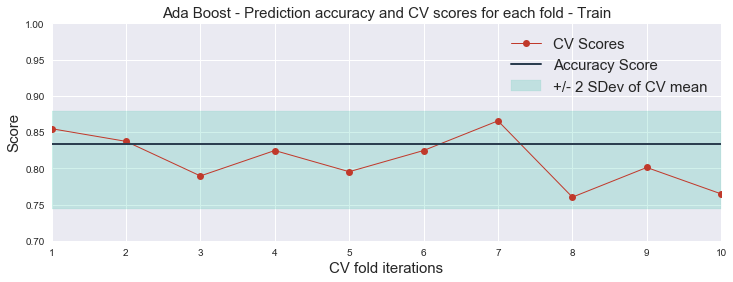

Ada Boost Model - (Validation) Prediction Accuracy: 0.80


In [143]:
BOOSTING_CLF = 'Ada Boost' # Model Title constant for Boosting Classifier

# Report Prediction accuracy on Train and Validation Data sets
ada_boost_train_acc, ada_boost_train_cv = get_classifier_accuracy(boost_models[optimal_boost_estimator]
                                                                  , X_train_scale, y_train, BOOSTING_CLF, TRAIN)
ada_boost_val_acc, ada_boost_val_cv = get_classifier_accuracy(boost_models[optimal_boost_estimator]
                                                              , X_val_scale, y_val, BOOSTING_CLF, VALIDATION)

<h2>Support Vector Machine (SVM) Classifier using SVC</h2>

In [144]:
# Parameter grid to use during the Randomized Grid search CV
parameters = {'kernel':['linear', 'rbf', 'sigmoid'], 'C': expon(scale=100), 'gamma': expon(scale=.1)}

# svc base classifier to use
svc = SVC(gamma="scale")

# Instantiate a Randomized search CV instance and fit the training data to determine the best estimator
rand_cv_clf = RandomizedSearchCV(svc, parameters, cv=5)
rand_cv_clf.fit(X_train_scale, y_train)
svc_clf = rand_cv_clf.best_estimator_

Support Vector Machine Model - (Train) Prediction Accuracy: 0.83
Support Vector Machine (Train) Cross Validation accuracy and 95 percent CI: 0.81 (+/- 0.06)


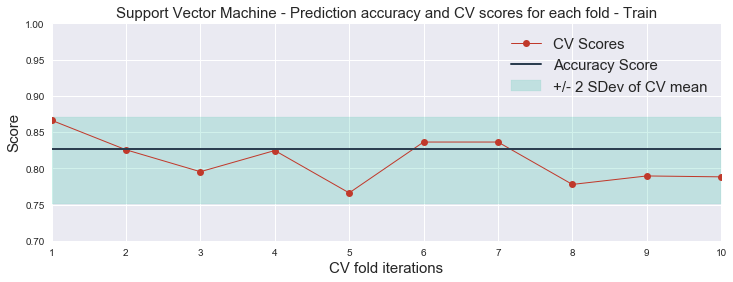

Support Vector Machine Model - (Validation) Prediction Accuracy: 0.82


In [185]:
SVM_CLF = 'Support Vector Machine' # Model Title constant for SVM Classifier

# Train the best svg classifier obtained from grid search with the train data set
svc_clf.fit(X_train_scale, y_train)

# Report Prediction accuracy on Train and Validation Data sets
svc_train_acc, svc_train_cv = get_classifier_accuracy(svc_clf, X_train_scale, y_train, SVM_CLF, TRAIN)
svc_val_acc, svc_val_cv = get_classifier_accuracy(svc_clf, X_val_scale, y_val, SVM_CLF, VALIDATION)

<h2>Neural Network Classifier</h2>

In [146]:
# Get the models training history
def plot_nn_training_history(model_history):
    ''' Method to plot the accuracy and loss statistics from the model's training history
      
       Args:
           model_history: History object obtained from the trained model
    '''
    # Initiate a figure for the plot
    fig = plt.figure(figsize=(24,8))

    # Create a subplot for the Accuracy stats
    plt.subplot(1, 2, 1)
    plt.plot(model_history.history['acc'])
    plt.plot(model_history.history['val_acc'])
    plt.ylim(bottom=0, top=1)
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'validation'])
    
    # Create a subplot for the Loss stats
    plt.subplot(1, 2, 2)
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    
    plt.show()

In [147]:
# Prepocess DF to NP arrays
X_train_nn = X_train_scale.values
y_train_nn = y_train.values

X_val_nn = X_val_scale.values
y_val_nn = y_val.values

In [148]:
# Instantiate a Sequential Model
ann_model = Sequential()

# Add a dropout regularization for input of the first hidden layer 
ann_model.add(Dropout(0.25))

# Add the 1st hidden layer
# 100 Nodes, and relu activation
ann_model.add(Dense(100, input_dim=X_train_nn.shape[1], activation='relu'
                    , kernel_regularizer=keras.regularizers.l2(0.01)))

# Add the 2nd hidden layer
# 50 Nodes, and relu activation
ann_model.add(Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))) 

# Add the 3rd hidden layer
# 50 Nodes, and relu activation
ann_model.add(Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))) 

# Add the 4th hidden layer
# 50 Nodes, and relu activation
ann_model.add(Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))) 

# Add the Output layer
# 1 Node for 2 output classes, and sigmoid activation
ann_model.add(Dense(1, activation='sigmoid')) 

# Compile the model with a SGD optimizer and binary_crossentropy loss function
ann_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model with the training data with 2000 training epochs with a batch size of 128
mod = ann_model.fit(X_train_nn, y_train_nn, epochs=2000, batch_size=128, validation_split=0.5, verbose=0)

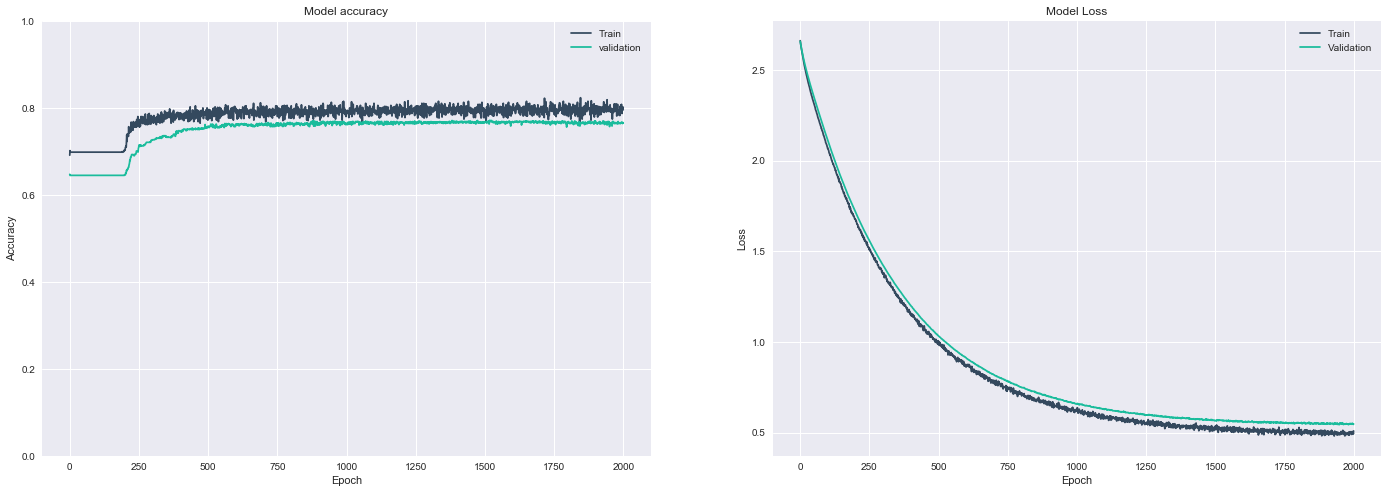

In [149]:
# Plot the accuracy and loss stats for the regulated model
plot_nn_training_history(ann_model.history)

In [150]:
# Evaluate the Regularized model accuracy on the training data
ann_model.evaluate(x=X_train_nn, y=y_train_nn, batch_size=64)

1711/1711 [==============================] - ETA:  - 0s 12us/step


[0.5087215290440237, 0.7849210992603536]

In [151]:
# Evaluate the Regularized model accuracy on the validation data
ann_model.evaluate(x=X_val_nn, y=y_val_nn, batch_size=64)

428/428 [==============================] - ETA:  - 0s 19us/step


[0.49052348482274566, 0.8130841093642689]

In [152]:
NN_CLF = 'Neural Net' # Model Title constant for NN Classifier

# Report Prediction accuracy on Train and Validation Data sets
ann_train_acc, ann_train_cv = get_classifier_accuracy(ann_model, X_train_nn, y_train_nn, NN_CLF, TRAIN)
ann_val_acc, ann_val_cv = get_classifier_accuracy(ann_model, X_val_nn, y_val_nn, NN_CLF, VALIDATION)

Neural Net Model - (Train) Prediction Accuracy: 0.78
Neural Net Model - (Validation) Prediction Accuracy: 0.81


<h2>Natural Language Processing (NLP)- Classification based on Topic Modeling</h2>

**Topic modeling based on Hashtags used in the tweet text messages of the user**

In [155]:
# Constants with STOP LIST and noise symbols to extract and clean from the topics
STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS))
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”"]

In [156]:
# Class to implement Text transformation using TransformerMixin from sklearn
class CleanTextTransformer(TransformerMixin):
   def transform(self, X, **transform_params):
        return [cleanText(text) for text in X]
   def fit(self, X, y=None, **fit_params):
        return self
   def get_params(self, deep=True):
        return {}

# utility method to clean text content
def cleanText(text):
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()
    return text

# utility method to tokenize text content
def tokenizeText(sample):
    tokens = parser(sample)
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    tokens = [tok for tok in tokens if tok not in STOPLIST]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    return tokens

# Utility method to report the top N Most informative topics from the topic based modeling classifier
def printNMostInformative(vectorizer, clf, N):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    topClass1 = coefs_with_fns[:N]
    topClass2 = coefs_with_fns[:-(N + 1):-1]
    class1_lst = []
    for feat in topClass1:
        feat_dict = {}
        feat_dict['Coefficient'] = feat[0]
        feat_dict['Topic'] = feat[1]
        class1_lst.append(feat_dict)
    cls1_df = pd.DataFrame(data=class1_lst)
        
    class2_lst = []
    for feat in topClass2:
        feat_dict = {}
        feat_dict['Coefficient'] = feat[0]
        feat_dict['Topic'] = feat[1]
        class2_lst.append(feat_dict)
    cls2_df = pd.DataFrame(data=class2_lst)
    return cls1_df, cls2_df

**Split Training and Validation data set from the consolidated data set**

In [157]:
# Extract the hash_tags feature containting the topic information and the response variable to form topic modeling data
topic_data_df = consolidated_ftrs_df[['hash_tags', 'bot_flg']]

# Spli the data set into Traing and Validation sets
topic_data_train, topic_data_val = train_test_split(topic_data_df, test_size = 0.2
                                                    , random_state=90, stratify=topic_data_df['bot_flg'])

# Form the Predictor and Response data sets for train and validation
X_topic_data_train = topic_data_train['hash_tags']
y_topic_data_train = topic_data_train['bot_flg']
X_topic_data_val = topic_data_val['hash_tags']
y_topic_data_val = topic_data_val['bot_flg']

**Fit the classification model to do Topic based classification**

In [138]:
# Instantiate a vectorizer to break down the multiple topics from the messages thru tokenization
vectorizer = CountVectorizer(tokenizer=tokenizeText, ngram_range=(1,1))

# Instantiate a LinearSVC classifier to use as part of the topic based classification
linear_svc_clf = LinearSVC()

# Define a pipeline that will clean the text content, vectorize it and fit the content using the SVC classifier
tpipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer), ('clf', linear_svc_clf)])

# Train the model based on the aggregated topics
tpipe.fit(X_topic_data_train, y_topic_data_train)

# Determine the top 10 topics used by the classifier during classification
cls1_df, cls2_df = printNMostInformative(vectorizer, linear_svc_clf, 10)

In [142]:
print("Top 10 topics used as features to predict: Class 1")
cls1_df.head(10)

Top 10 topics used as features to predict: Class 1


Coefficient               Topic
0    -0.910986            itrotter
1    -0.835408            lolsided
2    -0.835408  danielpadillaonggv
3    -0.831407      socialsecurity
4    -0.752205                 dad
5    -0.560587                kita
6    -0.558833               akhir
7    -0.532553            ifwedate
8    -0.502815        worldafroday
9    -0.498887      tuesdaythought

In [140]:
print("Top 10 topics used as features to predict: Class 2")
cls2_df.head(10)

Top 10 topics used as features to predict: Class 2


Coefficient        Topic
0     0.889049       trecru
1     0.806954         2017
2     0.543762   floodaware
3     0.498687        kueez
4     0.497928  freenazanin
5     0.497926    realhuman
6     0.497926  cuntscorner
7     0.497926     snoopdog
8     0.497926    eurekamag
9     0.495390         jb17

In [158]:
# Make predictions using the topic modeling classifier on the Test data set and calculate accuracy scores
tpreds_train = tpipe.predict(X_topic_data_train)
topic_train_acc = accuracy_score(y_topic_data_train, tpreds_train)

# Report the accuracy scores on Training data set
printmd_color("Topic Modeling Accuracy on %s data set - %0.2f" % (TRAIN, topic_train_acc), color='#2ecc71')

<h3 style="padding-top:10px;padding-bottom:10px;padding-left:5px;background-color:#2ecc71;">Topic Modeling Accuracy on Train data set - 0.99</h3>

Topic Model Model - (Train) Prediction Accuracy: 0.99
Topic Model (Train) Cross Validation accuracy and 95 percent CI: 0.70 (+/- 0.07)


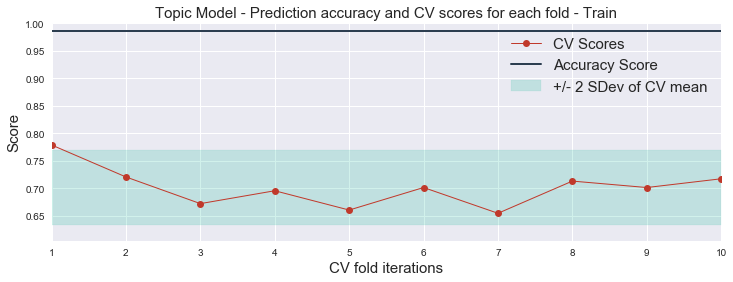

In [186]:
TOPIC_CLF = 'Topic Model'
topic_train_acc, topic_train_cv = get_classifier_accuracy(tpipe, X_topic_data_train
                                                          , y_topic_data_train, TOPIC_CLF, TRAIN)

In [159]:
# Make predictions using the topic modeling classifier on the validation data set and calculate accuracy scores
tpreds_val = tpipe.predict(X_topic_data_val)
topic_val_acc = accuracy_score(y_topic_data_val, tpreds_val)

# Report the accuracy scores on validation data set
printmd_color("Topic Modeling Accuracy on %s data set - %0.2f" % (VALIDATION, topic_val_acc), color='#2ecc71')

<h3 style="padding-top:10px;padding-bottom:10px;padding-left:5px;background-color:#2ecc71;">Topic Modeling Accuracy on Validation data set - 0.71</h3>

# <img style="float: left; padding-right: 10px; width: 50px" src="assets/layers-icon.png"> STACKING - Ensembling of multi Classifier output using a meta learner

In [160]:
# Calculate the Stacking metalearner predictions using provided classifiers for the given data set
def calculate_metalearner_predictions(models_to_compare, X_data, y_data, data_type=TRAIN):
    ''' Method to calculate metalearner predictions using stacked output of classifiers
        Also calculate the prediction accuracy based on the true output
        
       Args:
           models_to_compare: Dictionary containing various fitted classifier models to stack
           X_data: Input predictor data set for the classifier models
           y_data: True output data for the provided predictors
           data_type: Type of the data set that is passed. Default is TRAIN
      
       Returns:
           stacked_preds: array of predictions from the metalearner for the given data set
    '''    
    individual_preds = pd.DataFrame() # DF to store predictions from all the classifier models
    
    # Iterate through all classifier models and predict to combine meta learner output
    for title, model in models_to_compare.items():
        # Exclude PCA model for stacking
        if title != PCA_CLF and title != QDA_CLF:
            # Concat predictions of the current model as a new column to the prediction set
            individual_preds = pd.concat([individual_preds, pd.DataFrame(np.round(model.predict(X_data.values))
                                                                         , columns=[title])],axis=1)
        
    # Initialize a stacked predictions of all 0 output
    stacked_preds = np.zeros(individual_preds.shape[0])

    # Iterate through each classifier prediction and stack all true predictions
    for i in range(individual_preds.shape[0]):
        if individual_preds.values[i].mean() > 0.5:
            stacked_preds[i] = 1  
    
    # Calculate accuracy based on stacked predictions
    acc_scr = accuracy_score(y_data, stacked_preds)
       
    # Report Accuracy
    h3_start = '<h3 style="padding-top:10px;padding-bottom:10px;padding-left:5px;background-color:#1abc9c;">'
    h3_end = '</h3>'
    printmd(h3_start + 'Stacking Accuracy score on the %s data set - %0.2f' % (data_type, acc_scr) + h3_end)
    
    return stacked_preds

# Utility method for formatted print
def printmd_color(text, color='#1abc9c'):
    h3_start = '<h3 style="padding-top:10px;padding-bottom:10px;padding-left:5px;background-color:' + color + ';">'
    h3_end = '</h3>'
    printmd(h3_start + text + h3_end)

# <img style="float: left; padding-right: 10px; width: 50px" src="assets/stats.png"> Train and Validation - Prediction Results and Stats

<div class="exercise"> <b>Comparison of prediction accuracies across classifiers - TRAIN dataset</b> </div>

In [161]:
# Stacking Classification Accuracy score for Training Data
stacked_predictions_train = calculate_metalearner_predictions(models_to_compare, X_train_scale, y_train, TRAIN)

<h3 style="padding-top:10px;padding-bottom:10px;padding-left:5px;background-color:#1abc9c;">Stacking Accuracy score on the Train data set - 0.83</h3>

** Train ** Comparison Table of Accuracy stats for different classifiation models


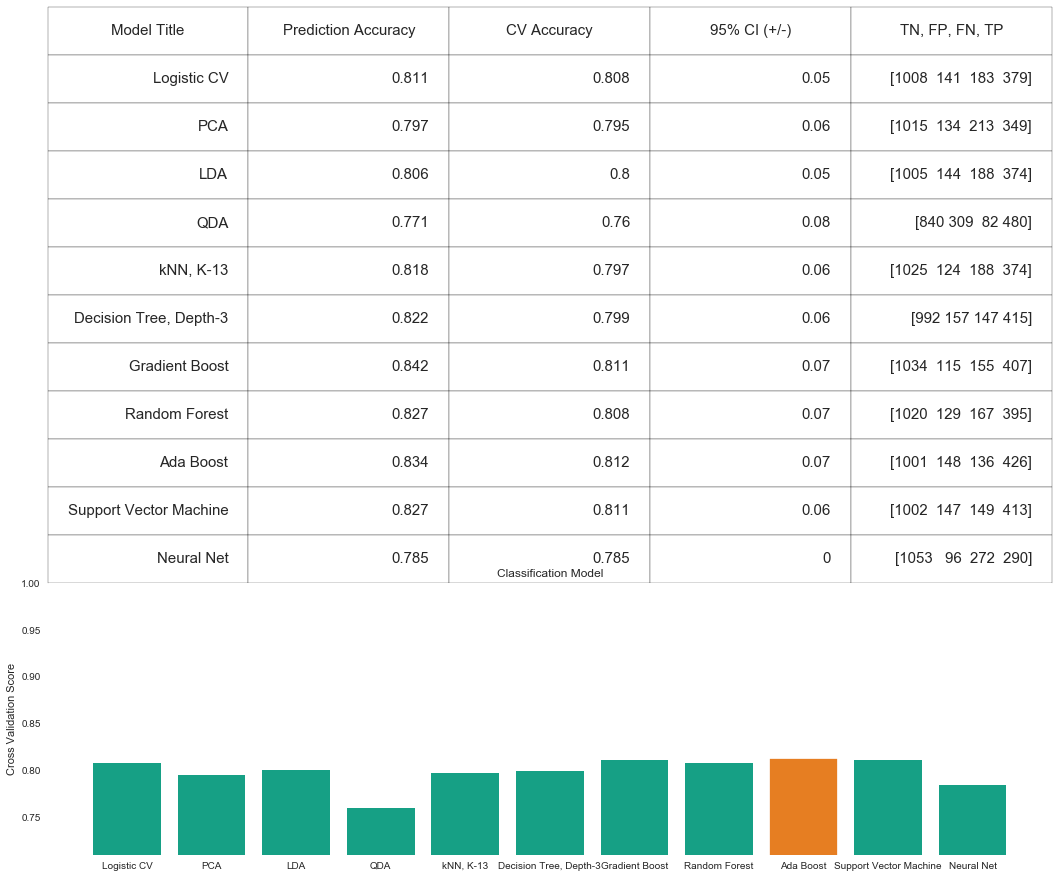

In [162]:
# Compare classifier accuracy stats for Training data
renderAccuracyStatsIable(acc_stats_table_data, TRAIN)

<div class="exercise"> <b>Comparison of prediction accuracies across classifiers - VALIDATION Dataset</b> </div>

In [163]:
# Stacking Classification Accuracy score for Validation Data
stacked_predictions_val = calculate_metalearner_predictions(models_to_compare, X_val_scale, y_val, VALIDATION)

<h3 style="padding-top:10px;padding-bottom:10px;padding-left:5px;background-color:#1abc9c;">Stacking Accuracy score on the Validation data set - 0.82</h3>

** Validation ** Comparison Table of Accuracy stats for different classifiation models


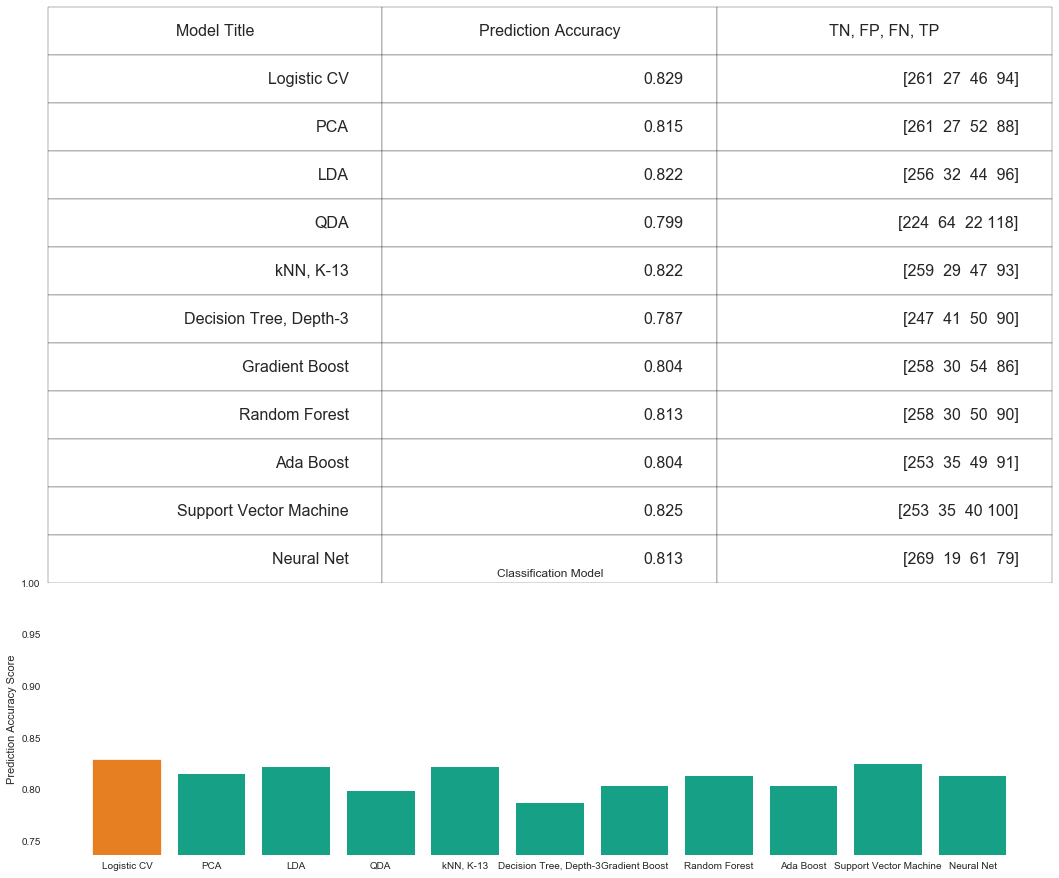

In [164]:
# Compare classifier accuracy stats for Validation data
renderAccuracyStatsIable(acc_stats_table_data, VALIDATION)

# <img style="float: left; padding-right: 10px; width: 50px" src="assets/test4.png"> Test Data Preparation and Models validation
<h2>Data Preparation</h2>

In [165]:
# Read the Pre-classified data set containing twitter user labeled as either Bots (1) or Human Users (0)
labelled_df_test = pd.read_csv('cresci_2017_test_prelabelled.csv')

# Determine no of users in the labelled data classified as Bots(1) and who are determined as Human Users (0)
labelled_df_test.groupby(['bot_flg']).count()

user_id
bot_flg         
0            526
1            392

In [166]:
# MARKED FOR EXECUTION AS NEEDED - NOTE - EXTRACTION TAKES A LONG TIME
# Download the latest 3000 tweets as json for each user in cresci_2017_test_prelabelled.csv (labelled_df_test)

# success_users_test, restricted_users_test = extract_tweets_for_users(labelled_df_test, TWEET_EXTRACT_LOCATION_TEST)

In [167]:
consolidated_ftrs_df_test = pd.read_csv(TWEET_EXTRACT_LOCATION_TEST + CONSOLIDATED_FEATURES)

# MARKED FOR EXECUTION AS NEEDED - NOTE - PARSING and CONSOLIDATES TAKES A LONG TIME
# Extract and consolidate all features for every user
#consolidated_ftrs_df_test = consolidate_features_at_user_level(TWEET_EXTRACT_LOCATION_TEST)

consolidated_ftrs_df_test = consolidated_ftrs_df_test.sample(frac=1)
consolidated_ftrs_df_test.describe()

user_id  default_profile  default_profile_image  favourites_count  followers_count  friends_count  listed_count  statuses_count  geo_enabled  protected    verified  has_extended_profile  is_translator  senti_polarity  senti_subjectivity  place_reference  possibly_sensitive  is_a_reply  is_quote_status  is_a_retweet  favorite_count  retweet_count  hash_tags_cnt   media_cnt  url_ref_cnt  symbols_cnt  user_ref_cnt  tweet_freq_hrs     bot_flg
count  7.590000e+02       759.000000             759.000000        759.000000       759.000000     759.000000    759.000000      759.000000   759.000000      759.0  759.000000            759.000000     759.000000      759.000000          759.000000       759.000000          759.000000  759.000000       759.000000    759.000000      759.000000     759.000000     759.000000  759.000000   759.000000   759.000000    759.000000      759.000000  759.000000
mean   2.422529e+09         0.351779               0.005270       7017.304348       723.781291     428.158103     18.015810    18922.671937     0.349144        0.0    0.001318              0.309618       0.001318        0.088758            0.270220         0.021095            0.006884    0.150647         0.042057      0.192339        1.432572    3001.980435       0.312464    0.149235     0.415457     0.000245      0.429975       26.046881    0.474308
std    6.407658e+08         0.477840               0.072452      17609.872465      3244.197278    1592.319104     31.884931    28996.646650     0.477014        0.0    0.036298              0.462641       0.036298        0.057007            0.096327         0.079940            0.079025    0.161396         0.076723      0.262976       12.590002    9142.138684       0.669913    0.204007     0.428245     0.003997      0.445413      128.101064    0.499669
min    8.572704e+08         0.000000               0.000000          0.000000         2.000000       0.000000      0.000000        4.000000     0.000000        0.0    0.000000              0.000000       0.000000       -0.078000            0.000000         0.000000            0.000000    0.000000         0.000000      0.000000        0.000000       0.000000       0.000000    0.000000     0.000000     0.000000      0.000000        0.000000    0.000000
25%    2.241075e+09         0.000000               0.000000          1.000000        43.000000      61.000000      0.000000     1117.500000     0.000000        0.0    0.000000              0.000000       0.000000        0.052000            0.209000         0.000000            0.000000    0.000000         0.000000      0.000000        0.031500       0.015000       0.021000    0.000000     0.055000     0.000000      0.000000        2.077000    0.000000
50%    2.548562e+09         0.000000               0.000000         57.000000       157.000000     160.000000      5.000000     8329.000000     0.000000        0.0    0.000000              0.000000       0.000000        0.080000            0.285000         0.000000            0.000000    0.111000         0.000000      0.019000        0.094000       8.667000       0.070000    0.091000     0.198000     0.000000      0.333000        7.182000    0.000000
75%    2.886263e+09         1.000000               0.000000       5345.000000       472.500000     364.500000     23.000000    23218.000000     1.000000        0.0    0.000000              1.000000       0.000000        0.117000            0.337500         0.000000            0.000000    0.268500         0.052000      0.324000        0.451000    1729.406000       0.234000    0.203500     1.002000     0.000000      0.727500       19.076000    1.000000
max    4.331280e+09         1.000000               1.000000     202812.000000     59649.000000   38571.000000    346.000000   259200.000000     1.000000        0.0    1.000000              1.000000       1.000000        0.422000            0.650000         0.831000            0.985000    0.924000         0.521000      1.000000      199.497000  170042.000000       4.4930

In [168]:
# Drop user_id from the dataframe as that is not needed for classification
consolidated_ftrs_df_test = consolidated_ftrs_df_test.drop(["user_id"], axis=1, errors='ignore')

# Drop the categorical values that does not seem to be providing value based on EDA
cols_to_drop = ['protected',  'verified', 'is_translator', 'possibly_sensitive', 'place_reference'
               , 'user_lang', 'default_profile_image', 'default_profile', 'symbols_cnt', 'hash_tags']
processed_data_df_test = consolidated_ftrs_df_test.drop(cols_to_drop, axis=1, errors='ignore')

# Split the test data after scaling through normalization
X_test_scale, y_test, dummyX, dummyY = split_train_and_test(processed_data_df_test, split_ratio=0.01)

<h2>Prediction Results on Test Data</h2>

**Ensembing based on Stacking**

In [169]:
stacked_predictions_test = calculate_metalearner_predictions(models_to_compare, X_test_scale, y_test, TEST)

<h3 style="padding-top:10px;padding-bottom:10px;padding-left:5px;background-color:#1abc9c;">Stacking Accuracy score on the Test data set - 0.81</h3>

<div class="exercise"> <b>Comparison of prediction accuracies across classifiers - TEST Dataset</b> </div>

** Test ** Comparison Table of Accuracy stats for different classifiation models


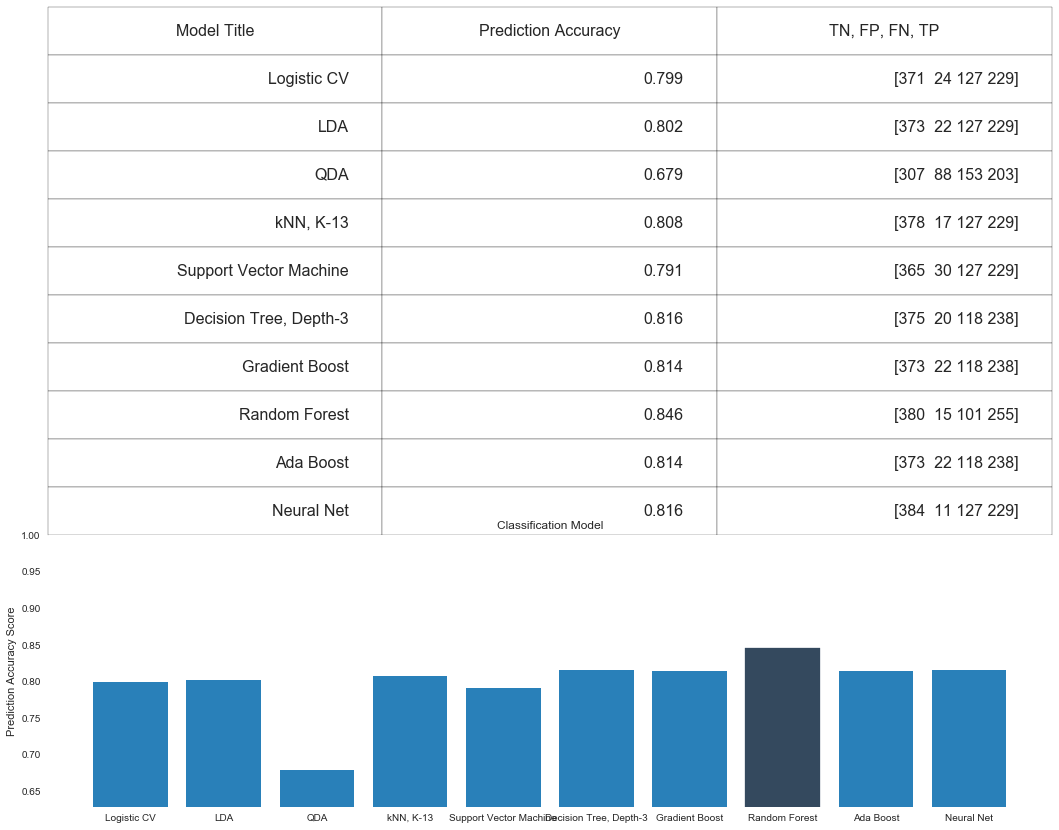

In [183]:
# Compare classifier accuracy stats for Test data
renderAccuracyStatsIable(acc_stats_table_data, TEST, 'Prediction Accuracy')

<div class="gc"> <b>Classification based on Topic Modeling - TEST Dataset</b> </div>

In [171]:
# Extract the Hast_tags feature containing the topics information and the response feature
topic_data_df_test = consolidated_ftrs_df_test[['hash_tags', 'bot_flg']]

# Form the test predictor and response data set for topic modeling based classification
X_topic_data_test = topic_data_df_test['hash_tags']
y_topic_data_test = topic_data_df_test['bot_flg']

# Predict based on the test topics
topic_test_preds = tpipe.predict(X_topic_data_test)

# Report Accuracy score from the Test predictions
topic_test_acc = accuracy_score(y_topic_data_test, topic_test_preds)
printmd_color("Topic Modeling Accuracy on %s data set - %0.2f" % (TEST, topic_test_acc), color='#2ecc71')

<h3 style="padding-top:10px;padding-bottom:10px;padding-left:5px;background-color:#2ecc71;">Topic Modeling Accuracy on Test data set - 0.85</h3>

<div class="exercise"> <b>Prediction accuracies across base classifiers - TEST Dataset</b> </div>

**Logistic Classifier CV**

In [172]:
lcv_test_acc, lcv_test_cv = get_classifier_accuracy(lcv_clf, X_test_scale, y_test, LOGISTIC_CLF, TEST)

Logistic CV Model - (Test) Prediction Accuracy: 0.80


**Linear Discriminant Analysis (LDA)**

In [173]:
lda_test_acc, lda_test_cv = get_classifier_accuracy(lda, X_test_scale, y_test, LDA_CLF, TEST)

LDA Model - (Test) Prediction Accuracy: 0.80


**Quadratic Discriminant Analysis (QDA)**

In [174]:
qda_test_acc, qda_test_cv = get_classifier_accuracy(qda, X_test_scale, y_test, QDA_CLF, TEST)

QDA Model - (Test) Prediction Accuracy: 0.68


**k Nearest Neigbors Classifier (kNN)**

In [175]:
knn_test_acc, knn_test_cv = get_classifier_accuracy(knn_models[optimal_k], X_test_scale, y_test, KNN_CLF, TEST)

kNN, K-13 Model - (Test) Prediction Accuracy: 0.81


**Support Vector Machine (SVM) using SVC**

In [176]:
svc_test_acc, svc_test_cv = get_classifier_accuracy(svc_clf, X_test_scale, y_test, SVM_CLF, TEST)

Support Vector Machine Model - (Test) Prediction Accuracy: 0.79


**Decision Tree**

In [177]:
dt_test_acc, dt_test_cv = get_classifier_accuracy(tree_models[optimal_depth], X_test_scale, y_test, DT_CLF, TEST)

Decision Tree, Depth-3 Model - (Test) Prediction Accuracy: 0.82


**Gradient Boost Ensembling**

In [178]:
gb_test_acc, gb_test_cv = get_classifier_accuracy(gb_models[optimal_gb_estimator]
                                                  , X_test_scale, y_test, GRAD_BOOST_CLF, TEST)

Gradient Boost Model - (Test) Prediction Accuracy: 0.81


**Random Forest Ensembling**

In [179]:
rf_test_acc, rf_test_cv = get_classifier_accuracy(rf_models[optimal_rf_estimator]
                                                  , X_test_scale, y_test, RAND_FOREST_CLF, TEST)

Random Forest Model - (Test) Prediction Accuracy: 0.85


**Adaptive Boosting Ensembling**

In [180]:
boost_test_acc, boost_test_cv = get_classifier_accuracy(boost_models[optimal_boost_estimator]
                                                        , X_test_scale, y_test, BOOSTING_CLF, TEST)

Ada Boost Model - (Test) Prediction Accuracy: 0.81


**Neural Networks**

In [181]:
ann_test_acc, ann_test_cv = get_classifier_accuracy(ann_model, X_test_scale.values, y_test.values, NN_CLF, TEST)

Neural Net Model - (Test) Prediction Accuracy: 0.82


In [182]:
stacked_predictions_test = calculate_metalearner_predictions(models_to_compare, X_test_scale, y_test, TEST)

<h3 style="padding-top:10px;padding-bottom:10px;padding-left:5px;background-color:#1abc9c;">Stacking Accuracy score on the Test data set - 0.81</h3>